# Analysis of hydrometeors and LWP, IWP

## Necessary libraries

In [1]:
# Libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import pandas as pd

import metpy
from metpy.units import units #had to install metpy
import wrf #had to install to have wrf-python things for vertical levels
import metpy.calc as mpcalc 

import pingouin as pg

import matplotlib.dates as mdates # formatting heatmaps
import datetime
from matplotlib.ticker import MaxNLocator, FuncFormatter, ScalarFormatter

## Datasets

In [2]:
# define main paths for observations and reanalysis + for simulations
obs_path = '/media/irene/Elements/Laptop_dec2023/Thesis_data/obs/'
sim_path = '/media/irene/Elements/wrf_micro/'

In [3]:
# Open datasets:
#to compute pressure levels need P and PB of WRF (already regridded to ERA5 lat and lon)
ds_ERA = xr.open_dataset(f'{obs_path}/ERA5-WTQ-MCScase.nc')
ds_Ptho, ds_PBtho = xr.open_dataset(f'{sim_path}/Thompson/reg_wrftho_P-16to24.nc'), xr.open_dataset(f'{sim_path}/Thompson/reg_wrftho_PB-16to24.nc')
ds_Pmor, ds_PBmor = xr.open_dataset(f'{sim_path}/Morrison/reg_wrfmor_P-16to24.nc'), xr.open_dataset(f'{sim_path}/Morrison/reg_wrfmor_PB-16to24.nc')
ds_Pcam, ds_PBcam = xr.open_dataset(f'{sim_path}/CAM/reg_wrfcam_P-16to24.nc'), xr.open_dataset(f'{sim_path}/CAM/reg_wrfcam_PB-16to24.nc')
ds_Pylin, ds_PBylin = xr.open_dataset(f'{sim_path}/Ylin/reg_wrfylin_P-16to24.nc'), xr.open_dataset(f'{sim_path}/Ylin/reg_wrfylin_PB-16to24.nc')
ds_Pwdm7, ds_PBwdm7 = xr.open_dataset(f'{sim_path}/WDM7/reg_wrfwdm7_P-16to24.nc'), xr.open_dataset(f'{sim_path}/WDM7/reg_wrfwdm7_PB-16to24.nc')
ds_Pwdm6, ds_PBwdm6 = xr.open_dataset(f'{sim_path}/WDM6/reg_wrfwdm6_P-16to24.nc'), xr.open_dataset(f'{sim_path}/WDM6/reg_wrfwdm6_PB-16to24.nc')

ds_rprtho = xr.open_dataset(f'{sim_path}/Thompson/reg_wrftho_PTO-16to24.nc')
ds_rprmor = xr.open_dataset(f'{sim_path}/Morrison/reg_wrfmor_PTO-16to24.nc')
ds_rprcam = xr.open_dataset(f'{sim_path}/CAM/reg_wrfcam_PTO-16to24.nc')
ds_rprylin = xr.open_dataset(f'{sim_path}/Ylin/reg_wrfylin_PTO-16to24.nc')
ds_rprwdm7 = xr.open_dataset(f'{sim_path}/WDM7/reg_wrfwdm7_PTO-16to24.nc')
ds_rprwdm6 = xr.open_dataset(f'{sim_path}/WDM6/reg_wrfwdm6_PTO-16to24.nc')
ds_prERA = xr.open_dataset(f'{obs_path}/ERA5-pr-acpr-t2m-olr-MCScase.nc')

## Cut spatial and temporal domain

In [4]:
start = '2008-07-16T00:00:00.000000000'
end = '2008-07-24T23:00:00.000000000'
ds_ERA = ds_ERA.sel(time=slice(start,end))
ds_prERA = ds_prERA.sel(time=slice(start,end))

#define time:
times=['2008-07-16', '2008-07-17', '2008-07-18', '2008-07-19', '2008-07-20', '2008-07-21', '2008-07-22', '2008-07-23', '2008-07-24']

In [5]:
# Define Sichuan Basin
lat1, lat2 = 26, 35
lon1, lon2 = 100, 114

#cut variables for vertical levels
ds_ERAc = ds_ERA.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_Pthoc, ds_PBthoc = ds_Ptho.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2)), ds_PBtho.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_Pmorc, ds_PBmorc = ds_Pmor.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2)), ds_PBmor.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_Pcamc, ds_PBcamc = ds_Pcam.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2)), ds_PBcam.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_Pylinc, ds_PBylinc = ds_Pylin.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2)), ds_PBylin.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_Pwdm7c, ds_PBwdm7c = ds_Pwdm7.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2)), ds_PBwdm7.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_Pwdm6c, ds_PBwdm6c = ds_Pwdm6.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2)), ds_PBwdm6.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))

ds_rprthoc = ds_rprtho.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_rprmorc = ds_rprmor.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_rprcamc = ds_rprcam.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_rprylinc = ds_rprylin.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_rprwdm7c = ds_rprwdm7.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_rprwdm6c = ds_rprwdm6.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_prERAc = ds_prERA.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))

## Fix vertical levels

In [6]:
# Compute pressure levels of wrf variables (to convert from wrf vertical coordinate system to ERA5 vertical coordinates)
thopr_lev = (ds_Pthoc.P + ds_PBthoc.PB)/100 #/100 is to have it in hPa
morpr_lev = (ds_Pmorc.P + ds_PBmorc.PB)/100 
campr_lev = (ds_Pcamc.P + ds_PBcamc.PB)/100
ylinpr_lev = (ds_Pylinc.P + ds_PBylinc.PB)/100
wdm7pr_lev = (ds_Pwdm7c.P + ds_PBwdm7c.PB)/100
wdm6pr_lev = (ds_Pwdm6c.P + ds_PBwdm6c.PB)/100

In [7]:
# Mean over time to be able to interpolate (cause interpolation is max for 3D variables)
thoprt_lev = thopr_lev.mean(dim=('XTIME'))
morprt_lev = morpr_lev.mean(dim=('XTIME'))
camprt_lev = campr_lev.mean(dim=('XTIME'))
ylinprt_lev = ylinpr_lev.mean(dim=('XTIME'))
wdm7prt_lev = wdm7pr_lev.mean(dim=('XTIME'))
wdm6prt_lev = wdm6pr_lev.mean(dim=('XTIME'))

In [8]:
# Mean over latitude to be able to interpolate (3d datasets) - this is for levels (don't have to do it again)
thoprla_lev = thopr_lev.mean(dim=('latitude'))
morprla_lev = morpr_lev.mean(dim=('latitude'))
camprla_lev = campr_lev.mean(dim=('latitude'))
ylinprla_lev = ylinpr_lev.mean(dim=('latitude'))
wdm7prla_lev = wdm7pr_lev.mean(dim=('latitude'))
wdm6prla_lev = wdm6pr_lev.mean(dim=('latitude'))

# Transpose to have bottom_top as first to be able to interpolate
thoprla_lev = thoprla_lev.transpose('bottom_top','XTIME','longitude')
morprla_lev = morprla_lev.transpose('bottom_top','XTIME','longitude')
camprla_lev = camprla_lev.transpose('bottom_top','XTIME','longitude')
ylinprla_lev = ylinprla_lev.transpose('bottom_top','XTIME','longitude')
wdm7prla_lev = wdm7prla_lev.transpose('bottom_top','XTIME','longitude')
wdm6prla_lev = wdm6prla_lev.transpose('bottom_top','XTIME','longitude')

## Hydrometeors

In [9]:
ulev=[30,50,70,100,125,150,175,200,225,250,300,350,400,450,500,550,600,650,700,750,775,800,825,850,875,900,925,950,975]

### Qcloud

In [10]:
# WRF
ds_qctho = xr.open_dataset(f'{sim_path}/Thompson/reg_wrftho_QC-16to24.nc')
ds_qcmor = xr.open_dataset(f'{sim_path}/Morrison/reg_wrfmor_QC-16to24.nc')
ds_qccam = xr.open_dataset(f'{sim_path}/CAM/reg_wrfcam_QC-16to24.nc')
ds_qcylin = xr.open_dataset(f'{sim_path}/Ylin/reg_wrfylin_QC-16to24.nc')
ds_qcwdm7 = xr.open_dataset(f'{sim_path}/WDM7/reg_wrfwdm7_QC-16to24.nc')
ds_qcwdm6 = xr.open_dataset(f'{sim_path}/WDM6/reg_wrfwdm6_QC-16to24.nc')
# ERA5
ds_clwERA = xr.open_dataset(f'{obs_path}/ERA5-cloudLiquidwater-MCScase.nc')
ds_ciwERA = xr.open_dataset(f'{obs_path}/ERA5-cloudIceWater-MCScase.nc')

ds_clwERA = ds_clwERA.sel(level=ulev)
ds_ciwERA = ds_ciwERA.sel(level=ulev)

In [11]:
# Define Sichuan Basin
lat1, lat2 = 26, 35
lon1, lon2 = 100, 114
#cut
ds_qcthoc = ds_qctho.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qcmorc = ds_qcmor.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qccamc = ds_qccam.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qcylinc = ds_qcylin.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qcwdm7c = ds_qcwdm7.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qcwdm6c = ds_qcwdm6.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_clwERA = ds_clwERA.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_ciwERA = ds_ciwERA.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))

In [12]:
# Mean over 2d space and time - and sum
imeanl_clwERA = ds_clwERA.mean(dim=('time','latitude', 'longitude'))
imeanl_ciwERA = ds_ciwERA.mean(dim=('time','latitude', 'longitude'))

In [13]:
# Mean over time
meant_qctho = ds_qcthoc.mean('XTIME')
meant_qcmor = ds_qcmorc.mean('XTIME')
meant_qccam = ds_qccamc.mean('XTIME')
meant_qcylin = ds_qcylinc.mean('XTIME')
meant_qcwdm7 = ds_qcwdm7c.mean('XTIME')
meant_qcwdm6 = ds_qcwdm6c.mean('XTIME')

# Interpolation of 3d data
dsi_qcthoc = wrf.interplevel(meant_qctho.QCLOUD, thoprt_lev, ulev)
dsi_qcmorc = wrf.interplevel(meant_qcmor.QCLOUD, morprt_lev, ulev)
dsi_qccamc = wrf.interplevel(meant_qccam.QCLOUD, camprt_lev, ulev)
dsi_qcylinc = wrf.interplevel(meant_qcylin.QCLOUD, ylinprt_lev, ulev)
dsi_qcwdm7c = wrf.interplevel(meant_qcwdm7.QCLOUD, wdm7prt_lev, ulev)
dsi_qcwdm6c = wrf.interplevel(meant_qcwdm6.QCLOUD, wdm6prt_lev, ulev)

# Mean over 2d space to do the graph that we want
imeanl_qctho = dsi_qcthoc.mean(dim=('latitude', 'longitude'))
imeanl_qcmor = dsi_qcmorc.mean(dim=('latitude', 'longitude'))
imeanl_qccam = dsi_qccamc.mean(dim=('latitude', 'longitude'))
imeanl_qcylin = dsi_qcylinc.mean(dim=('latitude', 'longitude'))
imeanl_qcwdm7 = dsi_qcwdm7c.mean(dim=('latitude', 'longitude'))
imeanl_qcwdm6 = dsi_qcwdm6c.mean(dim=('latitude', 'longitude'))

In [14]:
# Mean over space 
means_clwERA = (ds_clwERA.clwc).mean(dim=('latitude', 'longitude'))
means_ciwERA = (ds_ciwERA.ciwc).mean(dim=('latitude', 'longitude'))

# Transpose to have the time on x axis and levels on y
clwERA_st = means_clwERA.transpose(transpose_coords=True, missing_dims='raise')

In [15]:
# Q mean over latitude for variable and levels to have 3d data to interpolate
meanla_qctho = (ds_qcthoc.QCLOUD).mean(dim=('latitude'))
meanla_qcmor = (ds_qcmorc.QCLOUD).mean(dim=('latitude'))
meanla_qccam = (ds_qccamc.QCLOUD).mean(dim=('latitude'))
meanla_qcylin = (ds_qcylinc.QCLOUD).mean(dim=('latitude'))
meanla_qcwdm7 = (ds_qcwdm7c.QCLOUD).mean(dim=('latitude'))
meanla_qcwdm6 = (ds_qcwdm6c.QCLOUD).mean(dim=('latitude'))

# Change the order of dimensions to interpolate on levels (bottom_top has to be first)
meanla_qctho = meanla_qctho.transpose('bottom_top','XTIME','longitude')
meanla_qcmor = meanla_qcmor.transpose('bottom_top','XTIME','longitude')
meanla_qccam = meanla_qccam.transpose('bottom_top','XTIME','longitude')
meanla_qcylin = meanla_qcylin.transpose('bottom_top','XTIME','longitude')
meanla_qcwdm7 = meanla_qcwdm7.transpose('bottom_top','XTIME','longitude')
meanla_qcwdm6 = meanla_qcwdm6.transpose('bottom_top','XTIME','longitude')

# Interpolate 3d data
dsii_qcthoc = wrf.interplevel(meanla_qctho, thoprla_lev, ulev)
dsii_qcmorc = wrf.interplevel(meanla_qcmor, morprla_lev, ulev)
dsii_qccamc = wrf.interplevel(meanla_qccam, camprla_lev, ulev)
dsii_qcylinc = wrf.interplevel(meanla_qcylin, ylinprla_lev, ulev)
dsii_qcwdm7c = wrf.interplevel(meanla_qcwdm7, wdm7prla_lev, ulev)
dsii_qcwdm6c = wrf.interplevel(meanla_qcwdm6, wdm6prla_lev, ulev)

# Mean over longitude to have levels vs time to have heatmaps
iimeanl_qctho = dsii_qcthoc.mean(dim=('longitude'))
iimeanl_qcmor = dsii_qcmorc.mean(dim=('longitude'))
iimeanl_qccam = dsii_qccamc.mean(dim=('longitude'))
iimeanl_qcylin = dsii_qcylinc.mean(dim=('longitude'))
iimeanl_qcwdm7 = dsii_qcwdm7c.mean(dim=('longitude'))
iimeanl_qcwdm6 = dsii_qcwdm6c.mean(dim=('longitude'))

In [16]:
# ERA5: first you have to select shared levels with WRF interpolated (only 29)
dsl_qcERA = ds_clwERA.sel(level=ulev)
lev_qcERA = dsl_qcERA.level

# Then do the mean over 2d space of the equivalent of Qcloud
iimeanl_qcERA = dsl_qcERA.mean(dim=('latitude','longitude')).clwc
iimeanl_qcERA = iimeanl_qcERA.transpose('level', 'time')

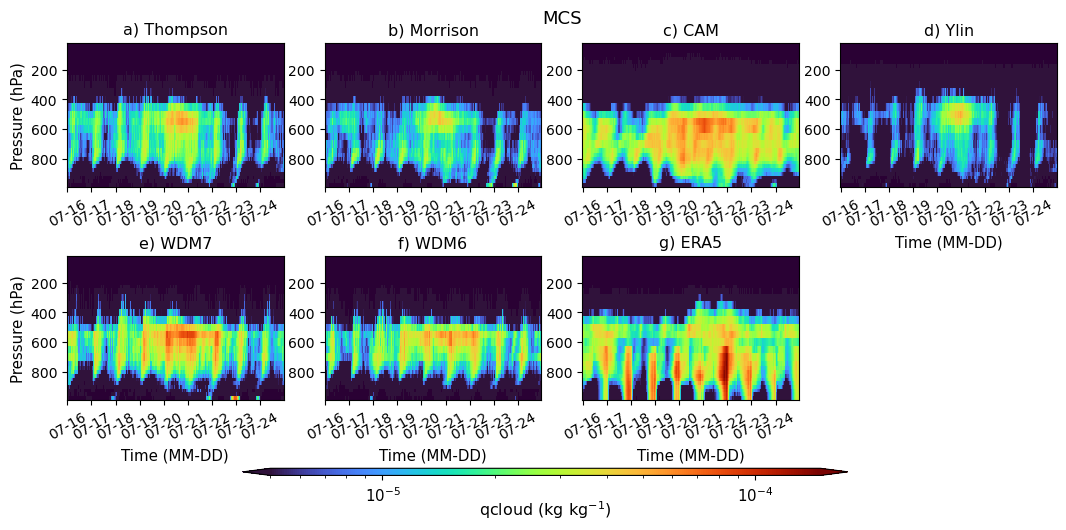

In [17]:
## maps for Article 
import matplotlib.dates as mdates
import datetime

time=['2008-07-16', '2008-07-17','2008-07-18', '2008-07-19','2008-07-20', '2008-07-21','2008-07-22', '2008-07-23','2008-07-24']
time = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in time]
date_format = mdates.DateFormatter('%m-%d')

# Interpolated heatmaps for Q  ------- POSTER Article
fig, axs = plt.subplots(2, 4, figsize=(11, 4.2))
axs=axs.flatten()
fig.suptitle('MCS', y=1.03, fontsize=13)

for i in range(0,7):
   axs[i].xaxis.set_major_formatter(date_format)
   axs[i].tick_params(axis='x', labelrotation = 30)
   axs[i].tick_params(axis='x', labelsize=10)  
   axs[i].tick_params(axis='y', labelsize=10)
   axs[i].set_facecolor('xkcd:very dark purple')


#
heatmap1 = axs[0].pcolormesh(iimeanl_qctho.XTIME, iimeanl_qctho.level, iimeanl_qctho, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000005,vmax=0.00015))
axs[0].set_title('a) Thompson', fontsize=11.5)
axs[0].set_ylabel('Pressure (hPa)', fontsize=10.8)
axs[0].invert_yaxis()
heatmap1.set_rasterized(True)

#
heatmap2 = axs[1].pcolormesh(iimeanl_qcmor.XTIME, iimeanl_qcmor.level, iimeanl_qcmor, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000005,vmax=0.00015))
axs[1].set_title('b) Morrison', fontsize=11.5)
axs[1].invert_yaxis()
heatmap2.set_rasterized(True)

#
heatmap3 = axs[2].pcolormesh(iimeanl_qccam.XTIME, iimeanl_qccam.level, iimeanl_qccam, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000005,vmax=0.00015))
axs[2].set_title('c) CAM', fontsize=11.5)
axs[2].invert_yaxis()
heatmap3.set_rasterized(True)

#
heatmap4 = axs[3].pcolormesh(iimeanl_qcylin.XTIME, iimeanl_qcylin.level, iimeanl_qcylin, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000005,vmax=0.00015))
axs[3].set_title('d) Ylin', fontsize=11.5)
axs[3].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[3].invert_yaxis()
heatmap4.set_rasterized(True)

#
heatmap5 = axs[4].pcolormesh(iimeanl_qcwdm7.XTIME, iimeanl_qcwdm7.level, iimeanl_qcwdm7, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000005,vmax=0.00015))
axs[4].set_title('e) WDM7', fontsize=11.5)
axs[4].set_ylabel('Pressure (hPa)', fontsize=10.8)
axs[4].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[4].invert_yaxis()
heatmap5.set_rasterized(True)

#
heatmap6 = axs[5].pcolormesh(iimeanl_qcwdm6.XTIME, iimeanl_qcwdm6.level, iimeanl_qcwdm6, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000005,vmax=0.00015))
axs[5].set_title('f) WDM6', fontsize=11.5)
axs[5].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[5].invert_yaxis()
heatmap6.set_rasterized(True)

# w
heatmap7 = axs[6].pcolormesh(clwERA_st.time, clwERA_st.level, clwERA_st, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000005,vmax=0.00015))                                          
axs[6].set_yticks([200,400,600,800])
axs[6].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[6].invert_yaxis()
axs[6].set_title('g) ERA5', fontsize=11.5)
heatmap7.set_rasterized(True)

axs[7].axis('off')


# Adjust layout to prevent clipping of axis labels
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.19, hspace=0.48)
# Add colorbar
cbar_ax = fig.add_axes([0.21, -0.08, 0.55, 0.017])
cbar=plt.colorbar(heatmap1, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label(r'qcloud (kg kg$^{-1}$)', fontsize = 11.5, labelpad=-4)
cbar.ax.tick_params(labelsize=10.8)

cbar.solids.set_edgecolor("face")
cbar.solids.set_rasterized(True)

# Save to SVG
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission_svg/qcloud-mcs-svg.svg',
            format='svg', dpi=400, bbox_inches='tight')

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/qcloud-mcs.png', dpi=400, bbox_inches='tight');


### Qrain

In [18]:
# Datasets
#WRF
ds_qrtho = xr.open_dataset(f'{sim_path}/Thompson/reg_wrftho_QRAIN-16to24.nc')
ds_qrmor = xr.open_dataset(f'{sim_path}/Morrison/reg_wrfmor_QRAIN-16to24.nc')
ds_qrcam = xr.open_dataset(f'{sim_path}/CAM/reg_wrfcam_QRAIN-16to24.nc')
ds_qrylin = xr.open_dataset(f'{sim_path}/Ylin/reg_wrfylin_QRAIN-16to24.nc')
ds_qrwdm7 = xr.open_dataset(f'{sim_path}/WDM7/reg_wrfwdm7_QRAIN-16to24.nc')
ds_qrwdm6 = xr.open_dataset(f'{sim_path}/WDM6/reg_wrfwdm6_QRAIN-16to24.nc')
#ERA5
ds_qrERA = xr.open_dataset(f'{obs_path}/ERA5-rainWater-MCScase.nc')

In [19]:
# Define Sichuan Basin
lat1, lat2 = 26, 35
lon1, lon2 = 100, 114
#cut
ds_qrthoc = ds_qrtho.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qrmorc = ds_qrmor.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qrcamc = ds_qrcam.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qrylinc = ds_qrylin.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qrwdm7c = ds_qrwdm7.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qrwdm6c = ds_qrwdm6.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qrERAc = ds_qrERA.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))

In [20]:
# Mean over time and 2D space for ERA5
ds_qrERA = ds_qrERA.sel(level=ulev)

imeanl_qrERA = ds_qrERA.mean(dim=('time','latitude', 'longitude'))

In [21]:
# Mean over time
meant_qrtho = ds_qrthoc.mean('XTIME')
meant_qrmor = ds_qrmorc.mean('XTIME')
meant_qrcam = ds_qrcamc.mean('XTIME')
meant_qrylin = ds_qrylinc.mean('XTIME')
meant_qrwdm7 = ds_qrwdm7c.mean('XTIME')
meant_qrwdm6 = ds_qrwdm6c.mean('XTIME')

# Interpolation of 3d data
dsi_qrthoc = wrf.interplevel(meant_qrtho.QRAIN, thoprt_lev, ulev)
dsi_qrmorc = wrf.interplevel(meant_qrmor.QRAIN, morprt_lev, ulev)
dsi_qrcamc = wrf.interplevel(meant_qrcam.QRAIN, camprt_lev, ulev)
dsi_qrylinc = wrf.interplevel(meant_qrylin.QRAIN, ylinprt_lev, ulev)
dsi_qrwdm7c = wrf.interplevel(meant_qrwdm7.QRAIN, wdm7prt_lev, ulev)
dsi_qrwdm6c = wrf.interplevel(meant_qrwdm6.QRAIN, wdm6prt_lev, ulev)

# Mean over 2d space to do the graph that we want
imeanl_qrtho = dsi_qrthoc.mean(dim=('latitude', 'longitude'))
imeanl_qrmor = dsi_qrmorc.mean(dim=('latitude', 'longitude'))
imeanl_qrcam = dsi_qrcamc.mean(dim=('latitude', 'longitude'))
imeanl_qrylin = dsi_qrylinc.mean(dim=('latitude', 'longitude'))
imeanl_qrwdm7 = dsi_qrwdm7c.mean(dim=('latitude', 'longitude'))
imeanl_qrwdm6 = dsi_qrwdm6c.mean(dim=('latitude', 'longitude'))

In [22]:
# Mean over space of ERA5 QRAIN
means_qrERA = (ds_qrERA.crwc).mean(dim=('latitude', 'longitude'))
# Transpose to have the time on x axis and levels on y
qrERA_st = means_qrERA.transpose(transpose_coords=True, missing_dims='raise')

In [23]:
# QRAIN mean over latitude for variable and levels to have 3d data to interpolate
meanla_qrtho = (ds_qrthoc.QRAIN).mean(dim=('latitude'))
meanla_qrmor = (ds_qrmorc.QRAIN).mean(dim=('latitude'))
meanla_qrcam = (ds_qrcamc.QRAIN).mean(dim=('latitude'))
meanla_qrylin = (ds_qrylinc.QRAIN).mean(dim=('latitude'))
meanla_qrwdm7 = (ds_qrwdm7c.QRAIN).mean(dim=('latitude'))
meanla_qrwdm6 = (ds_qrwdm6c.QRAIN).mean(dim=('latitude'))

# Change the order of dimensions to interpolate on levels (bottom_top has to be first)
meanla_qrtho = meanla_qrtho.transpose('bottom_top','XTIME','longitude')
meanla_qrmor = meanla_qrmor.transpose('bottom_top','XTIME','longitude')
meanla_qrcam = meanla_qrcam.transpose('bottom_top','XTIME','longitude')
meanla_qrylin = meanla_qrylin.transpose('bottom_top','XTIME','longitude')
meanla_qrwdm7 = meanla_qrwdm7.transpose('bottom_top','XTIME','longitude')
meanla_qrwdm6 = meanla_qrwdm6.transpose('bottom_top','XTIME','longitude')

# Interpolate 3d data
dsii_qrthoc = wrf.interplevel(meanla_qrtho, thoprla_lev, ulev)
dsii_qrmorc = wrf.interplevel(meanla_qrmor, morprla_lev, ulev)
dsii_qrcamc = wrf.interplevel(meanla_qrcam, camprla_lev, ulev)
dsii_qrylinc = wrf.interplevel(meanla_qrylin, ylinprla_lev, ulev)
dsii_qrwdm7c = wrf.interplevel(meanla_qrwdm7, wdm7prla_lev, ulev)
dsii_qrwdm6c = wrf.interplevel(meanla_qrwdm6, wdm6prla_lev, ulev)

# Mean over longitude to have levels vs time to have heatmaps
iimeanl_qrtho = dsii_qrthoc.mean(dim=('longitude'))
iimeanl_qrmor = dsii_qrmorc.mean(dim=('longitude'))
iimeanl_qrcam = dsii_qrcamc.mean(dim=('longitude'))
iimeanl_qrylin = dsii_qrylinc.mean(dim=('longitude'))
iimeanl_qrwdm7 = dsii_qrwdm7c.mean(dim=('longitude'))
iimeanl_qrwdm6 = dsii_qrwdm6c.mean(dim=('longitude'))

In [24]:
# ERA5: first you have to select shared levels with WRF interpolated (only 29)
dsl_qrERA = ds_qrERA.sel(level=ulev)
lev_qrERA = dsl_qrERA.level

# Then do the mean over 2d space for the equivalent of Qrain
iimeanl_qrERA = dsl_qrERA.mean(dim=('latitude','longitude')).crwc
iimeanl_qrERA = iimeanl_qrERA.transpose('level', 'time')

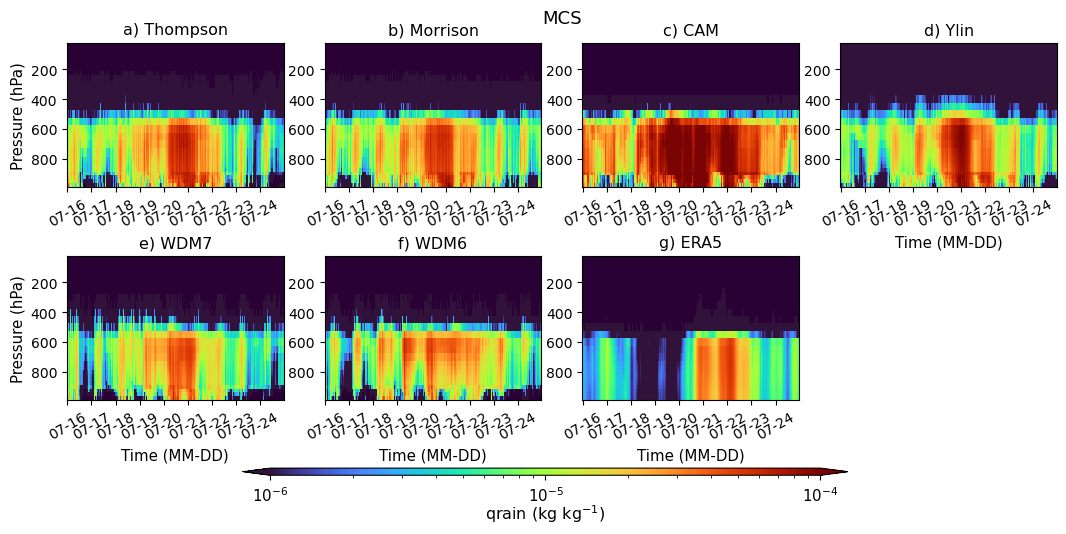

In [25]:
# Article
import matplotlib.dates as mdates
import datetime

time=['2008-07-16', '2008-07-17','2008-07-18', '2008-07-19','2008-07-20', '2008-07-21','2008-07-22', '2008-07-23','2008-07-24']
time = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in time]
date_format = mdates.DateFormatter('%m-%d')

# Interpolated heatmaps for Q  ------- POSTER Article
fig, axs = plt.subplots(2, 4, figsize=(11, 4.2))
axs=axs.flatten()
fig.suptitle('MCS', y=1.03, fontsize=13)

for i in range(0,7):
   axs[i].xaxis.set_major_formatter(date_format)
   axs[i].tick_params(axis='x', labelrotation = 30)
   axs[i].tick_params(axis='x', labelsize=10)  
   axs[i].tick_params(axis='y', labelsize=10)
   axs[i].set_facecolor('xkcd:very dark purple')

#
heatmap1 = axs[0].pcolormesh(iimeanl_qctho.XTIME, iimeanl_qctho.level, iimeanl_qrtho, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000001,vmax=0.0001))
axs[0].set_title('a) Thompson', fontsize=11.5)
axs[0].set_ylabel('Pressure (hPa)', fontsize=10.8)
axs[0].invert_yaxis()
heatmap1.set_rasterized(True)

#
heatmap2 = axs[1].pcolormesh(iimeanl_qcmor.XTIME, iimeanl_qcmor.level, iimeanl_qrmor, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000001,vmax=0.0001))
axs[1].set_title('b) Morrison', fontsize=11.5)
axs[1].invert_yaxis()
heatmap2.set_rasterized(True)

#
heatmap3 = axs[2].pcolormesh(iimeanl_qccam.XTIME, iimeanl_qccam.level, iimeanl_qrcam, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000001,vmax=0.0001))
axs[2].set_title('c) CAM', fontsize=11.5)
axs[2].invert_yaxis()
heatmap3.set_rasterized(True)

#
heatmap4 = axs[3].pcolormesh(iimeanl_qcylin.XTIME, iimeanl_qcylin.level, iimeanl_qrylin, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000001,vmax=0.0001))
axs[3].set_title('d) Ylin', fontsize=11.5)
axs[3].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[3].invert_yaxis()
heatmap4.set_rasterized(True)

#
heatmap5 = axs[4].pcolormesh(iimeanl_qcwdm7.XTIME, iimeanl_qcwdm7.level, iimeanl_qrwdm7, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000001,vmax=0.0001))
axs[4].set_title('e) WDM7', fontsize=11.5)
axs[4].set_ylabel('Pressure (hPa)', fontsize=10.8)
axs[4].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[4].invert_yaxis()
heatmap5.set_rasterized(True)

#
heatmap6 = axs[5].pcolormesh(iimeanl_qcwdm6.XTIME, iimeanl_qcwdm6.level, iimeanl_qrwdm6, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000001,vmax=0.0001))
axs[5].set_title('f) WDM6', fontsize=11.5)
axs[5].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[5].invert_yaxis()
heatmap6.set_rasterized(True)

# w
heatmap7 = axs[6].pcolormesh(clwERA_st.time, clwERA_st.level, qrERA_st, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000001,vmax=0.0001))                                          
axs[6].set_yticks([200,400,600,800])
axs[6].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[6].invert_yaxis()
axs[6].set_title('g) ERA5', fontsize=11.5)
heatmap7.set_rasterized(True)

axs[7].axis('off')

# Adjust layout to prevent clipping of axis labels
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.19, hspace=0.48)
# Add colorbar
cbar_ax = fig.add_axes([0.21, -0.08, 0.55, 0.017])
cbar=plt.colorbar(heatmap1, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label(r'qrain (kg kg$^{-1}$)', fontsize = 11.5, labelpad=-1)
cbar.ax.tick_params(labelsize=10.8) 

cbar.solids.set_edgecolor("face")
cbar.solids.set_rasterized(True)

# Save to SVG
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission_svg/qrain-mcs-svg.svg',
            format='svg', dpi=400, bbox_inches='tight')

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/qrain-mcs.png', dpi=400, bbox_inches='tight');

### Qsnow

In [26]:
# Datasets
#WRF
ds_qstho = xr.open_dataset(f'{sim_path}/Thompson/reg_wrftho_QSNOW-16to24.nc')
ds_qsmor = xr.open_dataset(f'{sim_path}/Morrison/reg_wrfmor_QSNOW-16to24.nc')
ds_qscam = xr.open_dataset(f'{sim_path}/CAM/reg_wrfcam_QSNOW-16to24.nc')
ds_qsylin = xr.open_dataset(f'{sim_path}/Ylin/reg_wrfylin_QSNOW-16to24.nc')
ds_qswdm7 = xr.open_dataset(f'{sim_path}/WDM7/reg_wrfwdm7_QSNOW-16to24.nc')
ds_qswdm6 = xr.open_dataset(f'{sim_path}/WDM6/reg_wrfwdm6_QSNOW-16to24.nc')
# ERA5
ds_qsERA = xr.open_dataset(f'{obs_path}/ERA5-snowWater-MCScase.nc')

In [27]:
# Define Sichuan Basin
lat1, lat2 = 26, 35
lon1, lon2 = 100, 114
#cut
ds_qsthoc = ds_qstho.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qsmorc = ds_qsmor.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qscamc = ds_qscam.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qsylinc = ds_qsylin.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qswdm7c = ds_qswdm7.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qswdm6c = ds_qswdm6.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qsERAc = ds_qsERA.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))

In [28]:
# Mean over time and 2D space for ERA5
imeanl_qsERA = ds_qsERA.mean(dim=('time','latitude', 'longitude'))

In [29]:
# Mean over time
meant_qstho = ds_qsthoc.mean('XTIME')
meant_qsmor = ds_qsmorc.mean('XTIME')
meant_qscam = ds_qscamc.mean('XTIME')
meant_qsylin = ds_qsylinc.mean('XTIME')
meant_qswdm7 = ds_qswdm7c.mean('XTIME')
meant_qswdm6 = ds_qswdm6c.mean('XTIME')

# Interpolation of 3d data
dsi_qsthoc = wrf.interplevel(meant_qstho.QSNOW, thoprt_lev, ulev)
dsi_qsmorc = wrf.interplevel(meant_qsmor.QSNOW, morprt_lev, ulev)
dsi_qscamc = wrf.interplevel(meant_qscam.QSNOW, camprt_lev, ulev)
dsi_qsylinc = wrf.interplevel(meant_qsylin.QSNOW, ylinprt_lev, ulev)
dsi_qswdm7c = wrf.interplevel(meant_qswdm7.QSNOW, wdm7prt_lev, ulev)
dsi_qswdm6c = wrf.interplevel(meant_qswdm6.QSNOW, wdm6prt_lev, ulev)

# Mean over 2d space to do the graph that we want
imeanl_qstho = dsi_qsthoc.mean(dim=('latitude', 'longitude'))
imeanl_qsmor = dsi_qsmorc.mean(dim=('latitude', 'longitude'))
imeanl_qscam = dsi_qscamc.mean(dim=('latitude', 'longitude'))
imeanl_qsylin = dsi_qsylinc.mean(dim=('latitude', 'longitude'))
imeanl_qswdm7 = dsi_qswdm7c.mean(dim=('latitude', 'longitude'))
imeanl_qswdm6 = dsi_qswdm6c.mean(dim=('latitude', 'longitude'))

In [30]:
# Mean over space of ERA5 QSNOW
means_qsERA = (ds_qsERA.cswc).mean(dim=('latitude', 'longitude'))
# Transpose to have the time on x axis and levels on y
qsERA_st = means_qsERA.transpose(transpose_coords=True, missing_dims='raise')

In [31]:
# QSNOW mean over latitude for variable and levels to have 3d data to interpolate
meanla_qstho = (ds_qsthoc.QSNOW).mean(dim=('latitude'))
meanla_qsmor = (ds_qsmorc.QSNOW).mean(dim=('latitude'))
meanla_qscam = (ds_qscamc.QSNOW).mean(dim=('latitude'))
meanla_qsylin = (ds_qsylinc.QSNOW).mean(dim=('latitude'))
meanla_qswdm7 = (ds_qswdm7c.QSNOW).mean(dim=('latitude'))
meanla_qswdm6 = (ds_qswdm6c.QSNOW).mean(dim=('latitude'))

# Change the order of dimensions to interpolate on levels (bottom_top has to be first)
meanla_qstho = meanla_qstho.transpose('bottom_top','XTIME','longitude')
meanla_qsmor = meanla_qsmor.transpose('bottom_top','XTIME','longitude')
meanla_qscam = meanla_qscam.transpose('bottom_top','XTIME','longitude')
meanla_qsylin = meanla_qsylin.transpose('bottom_top','XTIME','longitude')
meanla_qswdm7 = meanla_qswdm7.transpose('bottom_top','XTIME','longitude')
meanla_qswdm6 = meanla_qswdm6.transpose('bottom_top','XTIME','longitude')

# Interpolate 3d data
dsii_qsthoc = wrf.interplevel(meanla_qstho, thoprla_lev, ulev)
dsii_qsmorc = wrf.interplevel(meanla_qsmor, morprla_lev, ulev)
dsii_qscamc = wrf.interplevel(meanla_qscam, camprla_lev, ulev)
dsii_qsylinc = wrf.interplevel(meanla_qsylin, ylinprla_lev, ulev)
dsii_qswdm7c = wrf.interplevel(meanla_qswdm7, wdm7prla_lev, ulev)
dsii_qswdm6c = wrf.interplevel(meanla_qswdm6, wdm6prla_lev, ulev)

# Mean over longitude to have levels vs time to have heatmaps
iimeanl_qstho = dsii_qsthoc.mean(dim=('longitude'))
iimeanl_qsmor = dsii_qsmorc.mean(dim=('longitude'))
iimeanl_qscam = dsii_qscamc.mean(dim=('longitude'))
iimeanl_qsylin = dsii_qsylinc.mean(dim=('longitude'))
iimeanl_qswdm7 = dsii_qswdm7c.mean(dim=('longitude'))
iimeanl_qswdm6 = dsii_qswdm6c.mean(dim=('longitude'))

In [32]:
# ERA5: first you have to select shared levels with WRF interpolated (only 29)
dsl_qsERA = ds_qsERA.sel(level=ulev)
lev_qsERA = dsl_qsERA.level

# Then do the mean over 2d space
iimeanl_qsERA = dsl_qsERA.mean(dim=('latitude','longitude')).cswc
iimeanl_qsERA = iimeanl_qsERA.transpose('level', 'time')

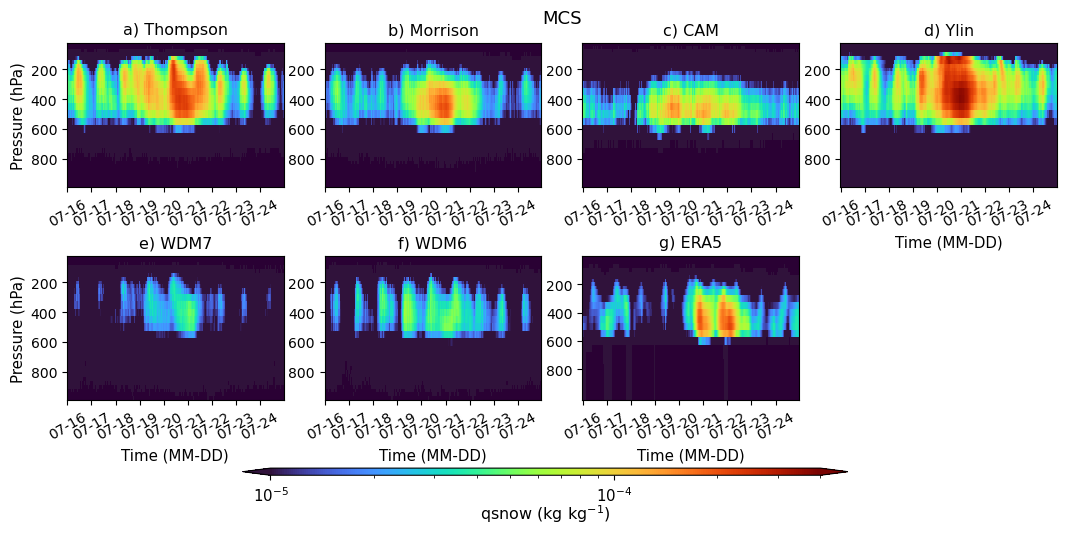

In [33]:
## maps for Article 
import matplotlib.dates as mdates
import datetime

time=['2008-07-16', '2008-07-17','2008-07-18', '2008-07-19','2008-07-20', '2008-07-21','2008-07-22', '2008-07-23','2008-07-24']
time = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in time]
date_format = mdates.DateFormatter('%m-%d')

# Interpolated heatmaps for Q  ------- POSTER Article
fig, axs = plt.subplots(2, 4, figsize=(11, 4.2))
axs=axs.flatten()
fig.suptitle('MCS', y=1.03, fontsize=13)

for i in range(0,7):
   axs[i].xaxis.set_major_formatter(date_format)
   axs[i].tick_params(axis='x', labelrotation = 30)
   axs[i].tick_params(axis='x', labelsize=10)  
   axs[i].tick_params(axis='y', labelsize=10)
   axs[i].set_facecolor('xkcd:very dark purple')

#
heatmap1 = axs[0].pcolormesh(iimeanl_qctho.XTIME, iimeanl_qctho.level, iimeanl_qstho, cmap='turbo',norm=mcolors.LogNorm(vmin=0.00001,vmax=0.0004))
axs[0].set_title('a) Thompson', fontsize=11.5)
axs[0].set_ylabel('Pressure (hPa)', fontsize=10.8)
axs[0].invert_yaxis()
heatmap1.set_rasterized(True)
#
heatmap2 = axs[1].pcolormesh(iimeanl_qcmor.XTIME, iimeanl_qcmor.level, iimeanl_qsmor, cmap='turbo',norm=mcolors.LogNorm(vmin=0.00001,vmax=0.0004))
axs[1].set_title('b) Morrison', fontsize=11.5)
axs[1].invert_yaxis()
heatmap2.set_rasterized(True)
#
heatmap3 = axs[2].pcolormesh(iimeanl_qccam.XTIME, iimeanl_qccam.level, iimeanl_qscam, cmap='turbo',norm=mcolors.LogNorm(vmin=0.00001,vmax=0.0004))
axs[2].set_title('c) CAM', fontsize=11.5)
axs[2].invert_yaxis()
heatmap3.set_rasterized(True)
#
heatmap4 = axs[3].pcolormesh(iimeanl_qcylin.XTIME, iimeanl_qcylin.level, iimeanl_qsylin, cmap='turbo',norm=mcolors.LogNorm(vmin=0.00001,vmax=0.0004))
axs[3].set_title('d) Ylin', fontsize=11.5)
axs[3].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[3].invert_yaxis()
heatmap4.set_rasterized(True)
#
heatmap5 = axs[4].pcolormesh(iimeanl_qcwdm7.XTIME, iimeanl_qcwdm7.level, iimeanl_qswdm7, cmap='turbo',norm=mcolors.LogNorm(vmin=0.00001,vmax=0.0004))
axs[4].set_title('e) WDM7', fontsize=11.5)
axs[4].set_ylabel('Pressure (hPa)', fontsize=10.8)
axs[4].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[4].invert_yaxis()
heatmap5.set_rasterized(True)
#
heatmap6 = axs[5].pcolormesh(iimeanl_qcwdm6.XTIME, iimeanl_qcwdm6.level, iimeanl_qswdm6, cmap='turbo',norm=mcolors.LogNorm(vmin=0.00001,vmax=0.0004))
axs[5].set_title('f) WDM6', fontsize=11.5)
axs[5].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[5].invert_yaxis()
heatmap6.set_rasterized(True)

# w
heatmap7 = axs[6].pcolormesh(qsERA_st.time, qsERA_st.level, qsERA_st, cmap='turbo',norm=mcolors.LogNorm(vmin=0.00001,vmax=0.0004))                                          
axs[6].set_yticks([200,400,600,800])
axs[6].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[6].invert_yaxis()
axs[6].set_title('g) ERA5', fontsize=11.5)
heatmap7.set_rasterized(True)

axs[7].axis('off')

# Adjust layout to prevent clipping of axis labels
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.19, hspace=0.48)
# Add colorbar
cbar_ax = fig.add_axes([0.21, -0.08, 0.55, 0.017])
cbar=plt.colorbar(heatmap1, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label(r'qsnow (kg kg$^{-1}$)', fontsize = 11.5, labelpad=-1)
cbar.ax.tick_params(labelsize=10.8) 

cbar.solids.set_edgecolor("face")
cbar.solids.set_rasterized(True)

# Save to SVG
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission_svg/qsnow-mcs-svg.svg',
            format='svg', dpi=400, bbox_inches='tight')

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/qsnow-mcs.png', dpi=400, bbox_inches='tight');

### Qice

In [34]:
# Datasets
#WRF
ds_qitho = xr.open_dataset(f'{sim_path}/Thompson/reg_wrftho_QICE-16to24.nc')
ds_qimor = xr.open_dataset(f'{sim_path}/Morrison/reg_wrfmor_QICE-16to24.nc')
ds_qicam = xr.open_dataset(f'{sim_path}/CAM/reg_wrfcam_QICE-16to24.nc')
ds_qiylin = xr.open_dataset(f'{sim_path}/Ylin/reg_wrfylin_QICE-16to24.nc')
ds_qiwdm7 = xr.open_dataset(f'{sim_path}/WDM7/reg_wrfwdm7_QICE-16to24.nc')
ds_qiwdm6 = xr.open_dataset(f'{sim_path}/WDM6/reg_wrfwdm6_QICE-16to24.nc')
# ERA5
ds_ciwERA = xr.open_dataset(f'{obs_path}/ERA5-cloudIceWater-MCScase.nc')

In [35]:
# Define Sichuan Basin
lat1, lat2 = 26, 35
lon1, lon2 = 100, 114
#cut
ds_qithoc = ds_qitho.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qimorc = ds_qimor.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qicamc = ds_qicam.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qiylinc = ds_qiylin.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qiwdm7c = ds_qiwdm7.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qiwdm6c = ds_qiwdm6.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_ciwERA = ds_ciwERA.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))

In [36]:
# Mean over 2d space and time for ERA
imeanl_ciwERA = ds_ciwERA.mean(dim=('time','latitude', 'longitude'))

In [37]:
# Mean over time
meant_qitho = ds_qithoc.mean('XTIME')
meant_qimor = ds_qimorc.mean('XTIME')
meant_qicam = ds_qicamc.mean('XTIME')
meant_qiylin = ds_qiylinc.mean('XTIME')
meant_qiwdm7 = ds_qiwdm7c.mean('XTIME')
meant_qiwdm6 = ds_qiwdm6c.mean('XTIME')

# Interpolation of 3d data
dsi_qithoc = wrf.interplevel(meant_qitho.QICE, thoprt_lev, ulev)
dsi_qimorc = wrf.interplevel(meant_qimor.QICE, morprt_lev, ulev)
dsi_qicamc = wrf.interplevel(meant_qicam.QICE, camprt_lev, ulev)
dsi_qiylinc = wrf.interplevel(meant_qiylin.QICE, ylinprt_lev, ulev)
dsi_qiwdm7c = wrf.interplevel(meant_qiwdm7.QICE, wdm7prt_lev, ulev)
dsi_qiwdm6c = wrf.interplevel(meant_qiwdm6.QICE, wdm6prt_lev, ulev)

# Mean over 2d space to do the graph that we want
imeanl_qitho = dsi_qithoc.mean(dim=('latitude', 'longitude'))
imeanl_qimor = dsi_qimorc.mean(dim=('latitude', 'longitude'))
imeanl_qicam = dsi_qicamc.mean(dim=('latitude', 'longitude'))
imeanl_qiylin = dsi_qiylinc.mean(dim=('latitude', 'longitude'))
imeanl_qiwdm7 = dsi_qiwdm7c.mean(dim=('latitude', 'longitude'))
imeanl_qiwdm6 = dsi_qiwdm6c.mean(dim=('latitude', 'longitude'))

imeanl_ciwERA = imeanl_ciwERA.sel(level=ulev)

In [38]:
# QICE mean over latitude for variable and levels to have 3d data to interpolate
meanla_qitho = (ds_qithoc.QICE).mean(dim=('latitude'))
meanla_qimor = (ds_qimorc.QICE).mean(dim=('latitude'))
meanla_qicam = (ds_qicamc.QICE).mean(dim=('latitude'))
meanla_qiylin = (ds_qiylinc.QICE).mean(dim=('latitude'))
meanla_qiwdm7 = (ds_qiwdm7c.QICE).mean(dim=('latitude'))
meanla_qiwdm6 = (ds_qiwdm6c.QICE).mean(dim=('latitude'))

# Change the order of dimensions to interpolate on levels (bottom_top has to be first)
meanla_qitho = meanla_qitho.transpose('bottom_top','XTIME','longitude')
meanla_qimor = meanla_qimor.transpose('bottom_top','XTIME','longitude')
meanla_qicam = meanla_qicam.transpose('bottom_top','XTIME','longitude')
meanla_qiylin = meanla_qiylin.transpose('bottom_top','XTIME','longitude')
meanla_qiwdm7 = meanla_qiwdm7.transpose('bottom_top','XTIME','longitude')
meanla_qiwdm6 = meanla_qiwdm6.transpose('bottom_top','XTIME','longitude')

# Interpolate 3d data
dsii_qithoc = wrf.interplevel(meanla_qitho, thoprla_lev, ulev)
dsii_qimorc = wrf.interplevel(meanla_qimor, morprla_lev, ulev)
dsii_qicamc = wrf.interplevel(meanla_qicam, camprla_lev, ulev)
dsii_qiylinc = wrf.interplevel(meanla_qiylin, ylinprla_lev, ulev)
dsii_qiwdm7c = wrf.interplevel(meanla_qiwdm7, wdm7prla_lev, ulev)
dsii_qiwdm6c = wrf.interplevel(meanla_qiwdm6, wdm6prla_lev, ulev)

# Mean over longitude to have levels vs time to have heatmaps
iimeanl_qitho = dsii_qithoc.mean(dim=('longitude'))
iimeanl_qimor = dsii_qimorc.mean(dim=('longitude'))
iimeanl_qicam = dsii_qicamc.mean(dim=('longitude'))
iimeanl_qiylin = dsii_qiylinc.mean(dim=('longitude'))
iimeanl_qiwdm7 = dsii_qiwdm7c.mean(dim=('longitude'))
iimeanl_qiwdm6 = dsii_qiwdm6c.mean(dim=('longitude'))

In [39]:
# ERA5: first you have to select shared levels with WRF interpolated (only 29)
dsl_qiERA = ds_ciwERA.sel(level=ulev)
lev_qiERA = dsl_qiERA.level

# Then do the mean over 2d space of the equivalent of Qice
iimeanl_qiERA = dsl_qiERA.mean(dim=('latitude','longitude')).ciwc
iimeanl_qiERA = iimeanl_qiERA.transpose('level', 'time')

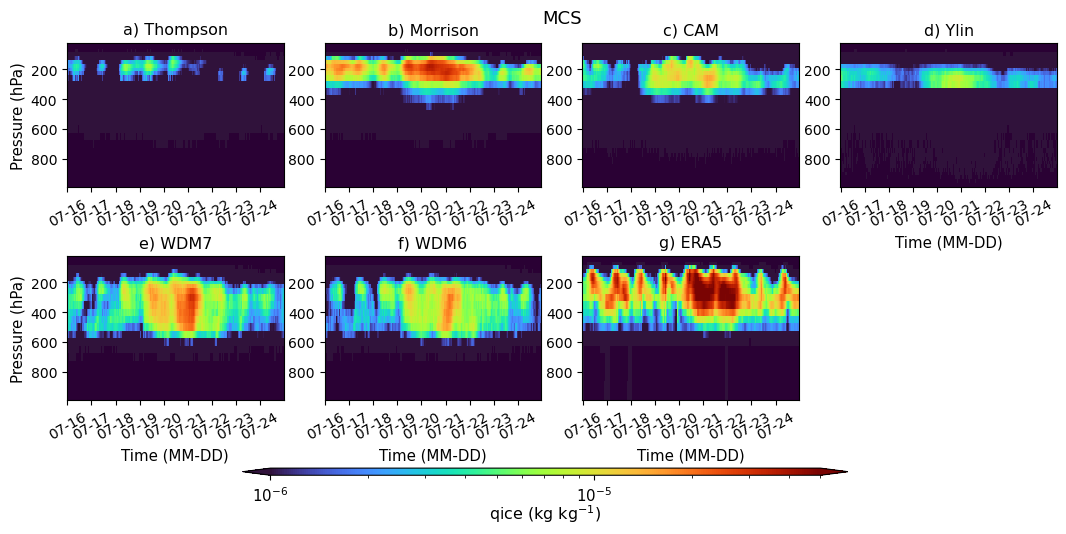

In [40]:
## maps for Article 
import matplotlib.dates as mdates
import datetime

time=['2008-07-16', '2008-07-17','2008-07-18', '2008-07-19','2008-07-20', '2008-07-21','2008-07-22', '2008-07-23','2008-07-24']
time = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in time]
date_format = mdates.DateFormatter('%m-%d')

# Interpolated heatmaps for Q  ------- POSTER Article
fig, axs = plt.subplots(2, 4, figsize=(11, 4.2))
axs=axs.flatten()
fig.suptitle('MCS', y=1.03, fontsize=13)

for i in range(0,7):
   axs[i].xaxis.set_major_formatter(date_format)
   axs[i].tick_params(axis='x', labelrotation = 30)
   axs[i].tick_params(axis='x', labelsize=10)  
   axs[i].tick_params(axis='y', labelsize=10)
   axs[i].set_facecolor('xkcd:very dark purple')

#
heatmap1 = axs[0].pcolormesh(iimeanl_qctho.XTIME, iimeanl_qctho.level, iimeanl_qitho, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000001,vmax=0.00005))
axs[0].set_title('a) Thompson', fontsize=11.5)
axs[0].set_ylabel('Pressure (hPa)', fontsize=10.8)
axs[0].invert_yaxis()
heatmap1.set_rasterized(True)

#
heatmap2 = axs[1].pcolormesh(iimeanl_qcmor.XTIME, iimeanl_qcmor.level, iimeanl_qimor, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000001,vmax=0.00005))
axs[1].set_title('b) Morrison', fontsize=11.5)
axs[1].invert_yaxis()
heatmap2.set_rasterized(True)

#
heatmap3 = axs[2].pcolormesh(iimeanl_qccam.XTIME, iimeanl_qccam.level, iimeanl_qicam, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000001,vmax=0.00005))
axs[2].set_title('c) CAM', fontsize=11.5)
axs[2].invert_yaxis()
heatmap3.set_rasterized(True)

#
heatmap4 = axs[3].pcolormesh(iimeanl_qcylin.XTIME, iimeanl_qcylin.level, iimeanl_qiylin, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000001,vmax=0.00005))
axs[3].set_title('d) Ylin', fontsize=11.5)
axs[3].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[3].invert_yaxis()
heatmap4.set_rasterized(True)

#
heatmap5 = axs[4].pcolormesh(iimeanl_qcwdm7.XTIME, iimeanl_qcwdm7.level, iimeanl_qiwdm7, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000001,vmax=0.00005))
axs[4].set_title('e) WDM7', fontsize=11.5)
axs[4].set_ylabel('Pressure (hPa)', fontsize=10.8)
axs[4].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[4].invert_yaxis()
heatmap5.set_rasterized(True)

#
heatmap6 = axs[5].pcolormesh(iimeanl_qcwdm6.XTIME, iimeanl_qcwdm6.level, iimeanl_qiwdm6, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000001,vmax=0.00005))
axs[5].set_title('f) WDM6', fontsize=11.5)
axs[5].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[5].invert_yaxis()
heatmap6.set_rasterized(True)


# w
heatmap7 = axs[6].pcolormesh(qsERA_st.time, iimeanl_qiERA.level, iimeanl_qiERA, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000001,vmax=0.00005))                                          
axs[6].set_yticks([200,400,600,800])
axs[6].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[6].invert_yaxis()
axs[6].set_title('g) ERA5', fontsize=11.5)
heatmap7.set_rasterized(True)

axs[7].axis('off')

# Adjust layout to prevent clipping of axis labels
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.19, hspace=0.48)
# Add colorbar
cbar_ax = fig.add_axes([0.21, -0.08, 0.55, 0.017])
cbar=plt.colorbar(heatmap1, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label(r'qice (kg kg$^{-1}$)', y=1, fontsize = 11.5, labelpad=-1)
cbar.ax.tick_params(labelsize=10.8) 

cbar.solids.set_edgecolor("face")
cbar.solids.set_rasterized(True)

# Save to SVG
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission_svg/qice-mcs-svg.svg',
            format='svg', dpi=400, bbox_inches='tight')

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/qice-mcs.png', dpi=400, bbox_inches='tight');

### Qgraupel

CAM and Ylin don't have it as well as ERA5

In [41]:
# Datasets
#WRF
ds_qgtho = xr.open_dataset(f'{sim_path}/Thompson/reg_wrftho_QGRAUP-16to24.nc')
ds_qgmor = xr.open_dataset(f'{sim_path}/Morrison/reg_wrfmor_QGRAUP-16to24.nc')
ds_qgwdm7 = xr.open_dataset(f'{sim_path}/WDM7/reg_wrfwdm7_QGRAUP-16to24.nc')
ds_qgwdm6 = xr.open_dataset(f'{sim_path}/WDM6/reg_wrfwdm6_QGRAUP-16to24.nc')

In [42]:
# Define Sichuan Basin
lat1, lat2 = 26, 35
lon1, lon2 = 100, 114
#cut
ds_qgthoc = ds_qgtho.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qgmorc = ds_qgmor.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qgwdm7c = ds_qgwdm7.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_qgwdm6c = ds_qgwdm6.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))

In [43]:
# Mean over time
meant_qgtho = ds_qgthoc.mean('XTIME')
meant_qgmor = ds_qgmorc.mean('XTIME')
meant_qgwdm7 = ds_qgwdm7c.mean('XTIME')
meant_qgwdm6 = ds_qgwdm6c.mean('XTIME')

# Interpolation of 3d data
dsi_qgthoc = wrf.interplevel(meant_qgtho.QGRAUP, thoprt_lev, ulev)
dsi_qgmorc = wrf.interplevel(meant_qgmor.QGRAUP, morprt_lev, ulev)
dsi_qgwdm7c = wrf.interplevel(meant_qgwdm7.QGRAUP, wdm7prt_lev, ulev)
dsi_qgwdm6c = wrf.interplevel(meant_qgwdm6.QGRAUP, wdm6prt_lev, ulev)

# Mean over 2d space to do the graph that we want
imeanl_qgtho = dsi_qgthoc.mean(dim=('latitude', 'longitude'))
imeanl_qgmor = dsi_qgmorc.mean(dim=('latitude', 'longitude'))
imeanl_qgwdm7 = dsi_qgwdm7c.mean(dim=('latitude', 'longitude'))
imeanl_qgwdm6 = dsi_qgwdm6c.mean(dim=('latitude', 'longitude'))

In [44]:
# QGRAUPEL mean over latitude for variable and levels to have 3d data to interpolate
meanla_qgtho = (ds_qgthoc.QGRAUP).mean(dim=('latitude'))
meanla_qgmor = (ds_qgmorc.QGRAUP).mean(dim=('latitude'))
meanla_qgwdm7 = (ds_qgwdm7c.QGRAUP).mean(dim=('latitude'))
meanla_qgwdm6 = (ds_qgwdm6c.QGRAUP).mean(dim=('latitude'))

# Change the order of dimensions to interpolate on levels (bottom_top has to be first)
meanla_qgtho = meanla_qgtho.transpose('bottom_top','XTIME','longitude')
meanla_qgmor = meanla_qgmor.transpose('bottom_top','XTIME','longitude')
meanla_qgwdm7 = meanla_qgwdm7.transpose('bottom_top','XTIME','longitude')
meanla_qgwdm6 = meanla_qgwdm6.transpose('bottom_top','XTIME','longitude')

# Interpolate 3d data
dsii_qgthoc = wrf.interplevel(meanla_qgtho, thoprla_lev, ulev)
dsii_qgmorc = wrf.interplevel(meanla_qgmor, morprla_lev, ulev)
dsii_qgwdm7c = wrf.interplevel(meanla_qgwdm7, wdm7prla_lev, ulev)
dsii_qgwdm6c = wrf.interplevel(meanla_qgwdm6, wdm6prla_lev, ulev)

# Mean over longitude to have levels vs time to have heatmaps
iimeanl_qgtho = dsii_qgthoc.mean(dim=('longitude'))
iimeanl_qgmor = dsii_qgmorc.mean(dim=('longitude'))
iimeanl_qgwdm7 = dsii_qgwdm7c.mean(dim=('longitude'))
iimeanl_qgwdm6 = dsii_qgwdm6c.mean(dim=('longitude'))

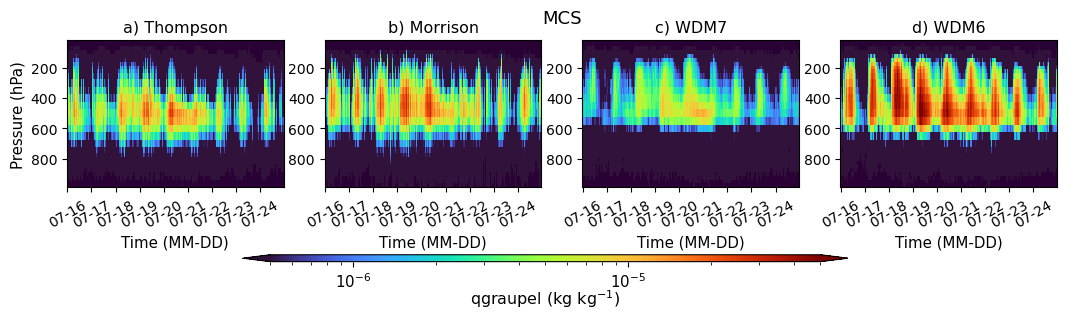

In [45]:
## maps for Article 
import matplotlib.dates as mdates
import datetime

time=['2008-07-16', '2008-07-17','2008-07-18', '2008-07-19','2008-07-20', '2008-07-21','2008-07-22', '2008-07-23','2008-07-24']
time = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in time]
date_format = mdates.DateFormatter('%m-%d')

# Interpolated heatmaps for Q  ------- POSTER Article
fig, axs = plt.subplots(1, 4, figsize=(11, 1.73))
axs=axs.flatten()
fig.suptitle('MCS', y=1.13, fontsize=13)

for i in range(0,4):
   axs[i].xaxis.set_major_formatter(date_format)
   axs[i].tick_params(axis='x', labelrotation = 30)
   axs[i].tick_params(axis='x', labelsize=10)  
   axs[i].tick_params(axis='y', labelsize=10)
   axs[i].set_facecolor('xkcd:very dark purple')

#
heatmap1 = axs[0].pcolormesh(iimeanl_qctho.XTIME, iimeanl_qctho.level, iimeanl_qgtho, cmap='turbo',norm=mcolors.LogNorm(vmin=0.0000005,vmax=0.00005))
axs[0].set_title('a) Thompson', fontsize=11.5)
axs[0].set_ylabel('Pressure (hPa)', fontsize=10.8)
axs[0].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[0].invert_yaxis()
heatmap1.set_rasterized(True)

#
heatmap2 = axs[1].pcolormesh(iimeanl_qcmor.XTIME, iimeanl_qcmor.level, iimeanl_qgmor, cmap='turbo',norm=mcolors.LogNorm(vmin=0.0000005,vmax=0.00005))
axs[1].set_title('b) Morrison', fontsize=11.5)
axs[1].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[1].invert_yaxis()
heatmap2.set_rasterized(True)


#
heatmap5 = axs[2].pcolormesh(iimeanl_qcwdm7.XTIME, iimeanl_qcwdm7.level, iimeanl_qgwdm7, cmap='turbo',norm=mcolors.LogNorm(vmin=0.0000005,vmax=0.00005))
axs[2].set_title('c) WDM7', fontsize=11.5)
axs[2].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[2].invert_yaxis()
heatmap5.set_rasterized(True)

#
heatmap6 = axs[3].pcolormesh(iimeanl_qcwdm6.XTIME, iimeanl_qcwdm6.level, iimeanl_qgwdm6, cmap='turbo',norm=mcolors.LogNorm(vmin=0.0000005,vmax=0.00005))
axs[3].set_title('d) WDM6', fontsize=11.5)
axs[3].set_xlabel('Time (MM-DD)', fontsize=10.8)
axs[3].invert_yaxis()
heatmap6.set_rasterized(True)


# Adjust layout to prevent clipping of axis labels
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.19, hspace=0.4)
# Add colorbar
cbar_ax = fig.add_axes([0.21, -0.33, 0.55, 0.04])
cbar=plt.colorbar(heatmap1, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label(r'qgraupel (kg kg$^{-1}$)', fontsize = 11.5, labelpad=-2)
cbar.ax.tick_params(labelsize=10.8) 

cbar.solids.set_edgecolor("face")
cbar.solids.set_rasterized(True)

# Save to SVG
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission_svg/qgraupel-mcs-svg.svg',
            format='svg', dpi=400, bbox_inches='tight')

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/qgraupel-mcs.png', dpi=400, bbox_inches='tight');

### Qhail

In [46]:
# Datasets
ds_qhwdm7 = xr.open_dataset(f'{sim_path}/WDM7/reg_wrfwdm7_QHAIL-16to24.nc')

#Define Sichuan Basin
lat1, lat2 = 26, 35
lon1, lon2 = 100, 114
#cut
ds_qhwdm7c = ds_qhwdm7.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))

# Mean over time
meant_qhwdm7 = ds_qhwdm7c.mean('XTIME')

# Interpolation of 3d data
dsi_qhwdm7c = wrf.interplevel(meant_qhwdm7.QHAIL, wdm7prt_lev, ulev)

# Mean over 2d space to do the graph that we want
imeanl_qhwdm7 = dsi_qhwdm7c.mean(dim=('latitude', 'longitude'))

In [47]:
# Q mean over latitude for variable and levels to have 3d data to interpolate
meanla_qhwdm7 = (ds_qhwdm7c.QHAIL).mean(dim=('latitude'))

# Change the order of dimensions to interpolate on levels (bottom_top has to be first)
meanla_qhwdm7 = meanla_qhwdm7.transpose('bottom_top','XTIME','longitude')

# Interpolate 3d data
dsii_qhwdm7c = wrf.interplevel(meanla_qhwdm7, wdm7prla_lev, ulev)

# Mean over longitude to have levels vs time to have heatmaps
iimeanl_qhwdm7 = dsii_qhwdm7c.mean(dim=('longitude'))

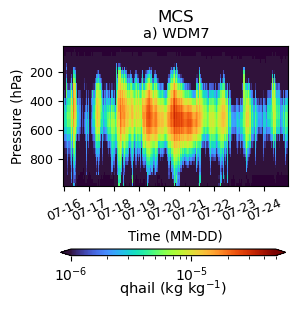

In [48]:
## maps for Article 
import matplotlib.dates as mdates
import datetime

time=['2008-07-16', '2008-07-17','2008-07-18', '2008-07-19','2008-07-20', '2008-07-21','2008-07-22', '2008-07-23','2008-07-24']
time = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in time]
date_format = mdates.DateFormatter('%m-%d')

# Interpolated heatmaps for Q  ------- POSTER Article
fig, axs = plt.subplots(1, 1, figsize=(2.5, 1.65))
#axs=axs.flatten()
fig.suptitle('MCS', y=1.17)

axs.xaxis.set_major_formatter(date_format)
axs.tick_params(axis='x', labelrotation = 25)
axs.tick_params(axis='x', labelsize=9)  
axs.tick_params(axis='y', labelsize=9)
axs.set_facecolor('xkcd:very dark purple')

#
heatmap5 = axs.pcolormesh(iimeanl_qcwdm7.XTIME, iimeanl_qcwdm7.level, iimeanl_qhwdm7, cmap='turbo',norm=mcolors.LogNorm(vmin=0.000001,vmax=0.00005))
axs.set_title('a) WDM7', fontsize=10.5)
axs.set_ylabel('Pressure (hPa)', fontsize=9.5)
axs.set_xlabel('Time (MM-DD)', fontsize=9.5)
axs.invert_yaxis()
heatmap5.set_rasterized(True)


# Adjust layout to prevent clipping of axis labels
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.17, hspace=0.4)
# Add colorbar
cbar_ax = fig.add_axes([0.04, -0.32, 0.9, 0.04])
cbar=plt.colorbar(heatmap5, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label(r'qhail (kg kg$^{-1}$)', fontsize = 10.5, labelpad=-4)
cbar.solids.set_edgecolor("face")
cbar.solids.set_rasterized(True)

# Save to SVG
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission_svg/qhail-mcs-svg.svg',
            format='svg', dpi=400, bbox_inches='tight')

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/qhail-mcs.png', dpi=400, bbox_inches='tight');

## All hydrometeors

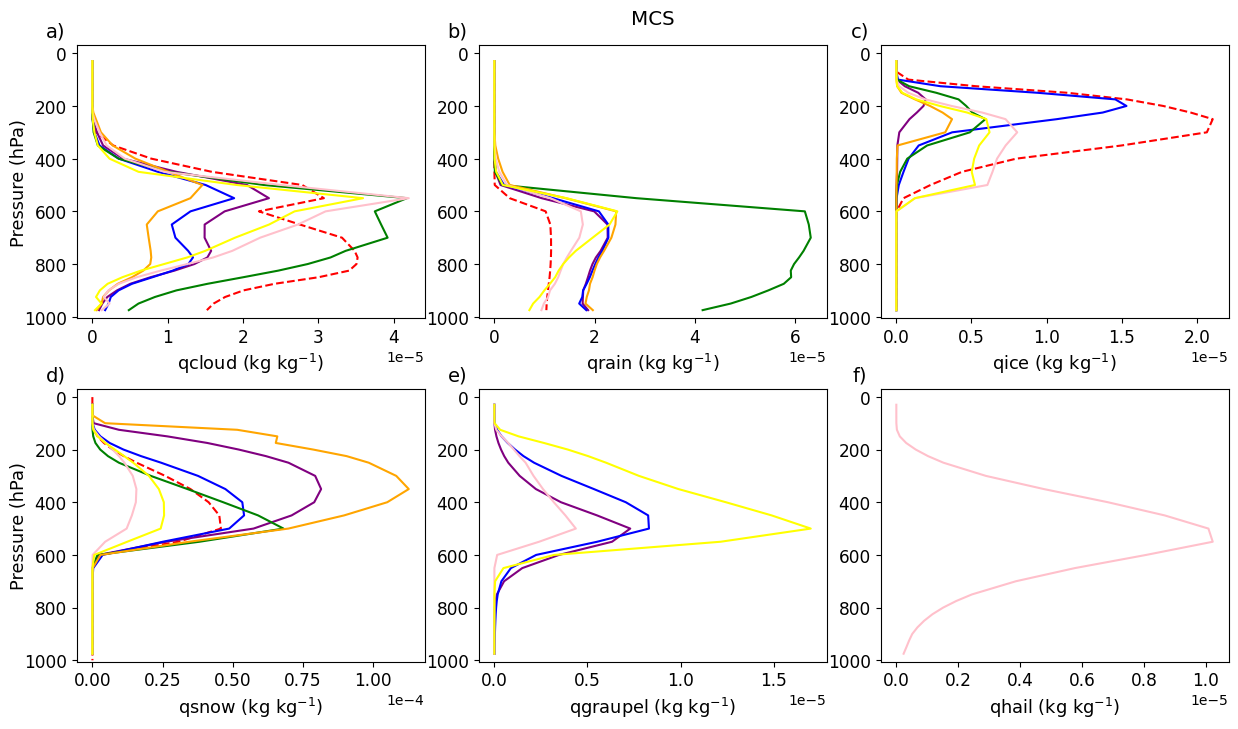

In [64]:
# Plot Qs
fig, axs = plt.subplots(2, 3, figsize=(12.8,7.25))
axs = axs.flatten()
fig.suptitle('MCS', y=1, fontsize=14.3)

for ax in axs:
    ax.tick_params(axis='both', labelsize=12.2)
    ax.set_ylim(-30,1005)

# Plot Qcloud
axs[0].plot(imeanl_clwERA.clwc, imeanl_qstho.level, linestyle='dashed', color='r', label='ERA5')
axs[0].plot(imeanl_qctho, imeanl_qstho.level, color='purple', label='Thompson')
axs[0].plot(imeanl_qcmor, imeanl_qstho.level, color='blue', label='Morrison')
axs[0].plot(imeanl_qccam, imeanl_qstho.level, color='green', label='CAM')
axs[0].plot(imeanl_qcylin, imeanl_qstho.level, color='orange', label='Ylin')
axs[0].plot(imeanl_qcwdm7, imeanl_qstho.level, color='pink', label='WDM7')
axs[0].plot(imeanl_qcwdm6, imeanl_qstho.level, color='yellow', label='WDM6')
axs[0].set_xlabel('qcloud (kg kg$^{-1}$)', fontsize=12.8)
axs[0].set_ylabel('Pressure (hPa)', fontsize=12.8, labelpad = -3)
axs[0].invert_yaxis()
axs[0].set_title('a)', fontsize=14, x=-0.06)

# Force scientific notation on the x-axis
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 1))  # Force scientific notation for values outside this range

# Optionally, turn on the offset notation (1e4 type of offset)
axs[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axs[3].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Plot Qrain
axs[1].plot(imeanl_qrERA.crwc, imeanl_qrERA.level, linestyle='dashed', color='r', label='ERA5')
axs[1].plot(imeanl_qrtho, imeanl_qstho.level, color='purple', label='Thompson')
axs[1].plot(imeanl_qrmor, imeanl_qstho.level, color='blue', label='Morrison')
axs[1].plot(imeanl_qrcam, imeanl_qstho.level, color='green', label='CAM')
axs[1].plot(imeanl_qrylin, imeanl_qstho.level, color='orange', label='Ylin')
axs[1].plot(imeanl_qrwdm7, imeanl_qstho.level, color='pink', label='WDM7')
axs[1].plot(imeanl_qrwdm6, imeanl_qstho.level, color='yellow', label='WDM6')
axs[1].set_xlabel('qrain (kg kg$^{-1}$)', fontsize=12.8,)
axs[1].invert_yaxis()
axs[1].set_title('b)', fontsize=14, x=-0.06)


# Plot Qice
axs[2].plot(imeanl_ciwERA.ciwc, imeanl_qstho.level, linestyle='dashed', color='r', label='ERA5')
axs[2].plot(imeanl_qitho, imeanl_qitho.level, color='purple', label='Thompson')
axs[2].plot(imeanl_qimor, imeanl_qitho.level, color='blue', label='Morrison')
axs[2].plot(imeanl_qicam, imeanl_qitho.level, color='green', label='CAM')
axs[2].plot(imeanl_qiylin, imeanl_qitho.level, color='orange', label='Ylin')
axs[2].plot(imeanl_qiwdm7, imeanl_qitho.level, color='pink', label='WDM7')
axs[2].plot(imeanl_qiwdm6, imeanl_qitho.level, color='yellow', label='WDM6')
axs[2].set_xlabel('qice (kg kg$^{-1}$)', fontsize=12.8,)
axs[2].invert_yaxis()
axs[2].set_title('c)', fontsize=14, x=-0.06)


# Plot Qsnow
axs[3].plot(imeanl_qsERA.cswc, imeanl_qsERA.level, linestyle='dashed', color='r', label='ERA5')
axs[3].plot(imeanl_qstho, imeanl_qstho.level, color='purple', label='Thompson')
axs[3].plot(imeanl_qsmor, imeanl_qstho.level, color='blue', label='Morrison')
axs[3].plot(imeanl_qscam, imeanl_qstho.level, color='green', label='CAM')
axs[3].plot(imeanl_qsylin, imeanl_qstho.level, color='orange', label='Ylin')
axs[3].plot(imeanl_qswdm7, imeanl_qstho.level, color='pink', label='WDM7')
axs[3].plot(imeanl_qswdm6, imeanl_qstho.level, color='yellow', label='WDM6')
axs[3].set_xlabel('qsnow (kg kg$^{-1}$)', fontsize=12.8,)
axs[3].invert_yaxis()
axs[3].set_title('d)', fontsize=14, x=-0.06)
axs[3].set_ylabel('Pressure (hPa)', fontsize=12.8, labelpad = -3)


# Plot Qgraupel
axs[4].plot(imeanl_qgtho, imeanl_qgtho.level, color='purple', label='Thompson')
axs[4].plot(imeanl_qgmor, imeanl_qstho.level, color='blue', label='Morrison')
axs[4].plot(imeanl_qgwdm7, imeanl_qstho.level, color='pink', label='WDM7')
axs[4].plot(imeanl_qgwdm6, imeanl_qstho.level, color='yellow', label='WDM6')
axs[4].set_xlabel('qgraupel (kg kg$^{-1}$)', fontsize=12.8,)
axs[4].invert_yaxis()
axs[4].set_title('e)', fontsize=14, x=-0.06)

# Plot Qhail
axs[5].plot(imeanl_qhwdm7, imeanl_qhwdm7.level, color='pink', label='WDM7')
axs[5].set_xlabel('qhail (kg kg$^{-1}$)', fontsize=12.8,)
axs[5].invert_yaxis()
axs[5].set_title('f)', fontsize=14, x=-0.06)

#axs[3].legend(loc='upper right', ncol=7, bbox_to_anchor=(2.7, -0.22), fontsize=12.8,)

# Adjust layout to prevent clipping of axis labels
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.155, hspace=0.26)

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/hydro-mcs.png', dpi=400, bbox_inches='tight');

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission_svg/hydro-mcs-svg.svg', format='svg', dpi=400, bbox_inches='tight')


In [50]:
# Compute sum of mixing ratios of liquid and solid water species
Qliquid_tho = imeanl_qctho + imeanl_qrtho
Qliquid_mor = imeanl_qcmor + imeanl_qrmor
Qliquid_cam = imeanl_qccam + imeanl_qrcam
Qliquid_ylin = imeanl_qcylin + imeanl_qrylin
Qliquid_wdm7 = imeanl_qcwdm7 + imeanl_qrwdm7
Qliquid_wdm6 = imeanl_qcwdm6 + imeanl_qrwdm6
Qliquid_ERA = imeanl_clwERA.clwc + imeanl_qrERA.crwc

Qsolid_tho = imeanl_qitho + imeanl_qstho  + imeanl_qgtho 
Qsolid_mor = imeanl_qimor + imeanl_qsmor  + imeanl_qgmor 
Qsolid_cam = imeanl_qicam + imeanl_qscam 
Qsolid_ylin = imeanl_qiylin + imeanl_qsylin 
Qsolid_wdm7 = imeanl_qiwdm7 + imeanl_qswdm7 + imeanl_qgwdm7 + imeanl_qhwdm7 
Qsolid_wdm6 = imeanl_qiwdm6 + imeanl_qswdm6 + imeanl_qgwdm6 
Qsolid_ERA = imeanl_ciwERA.ciwc + imeanl_qsERA.cswc

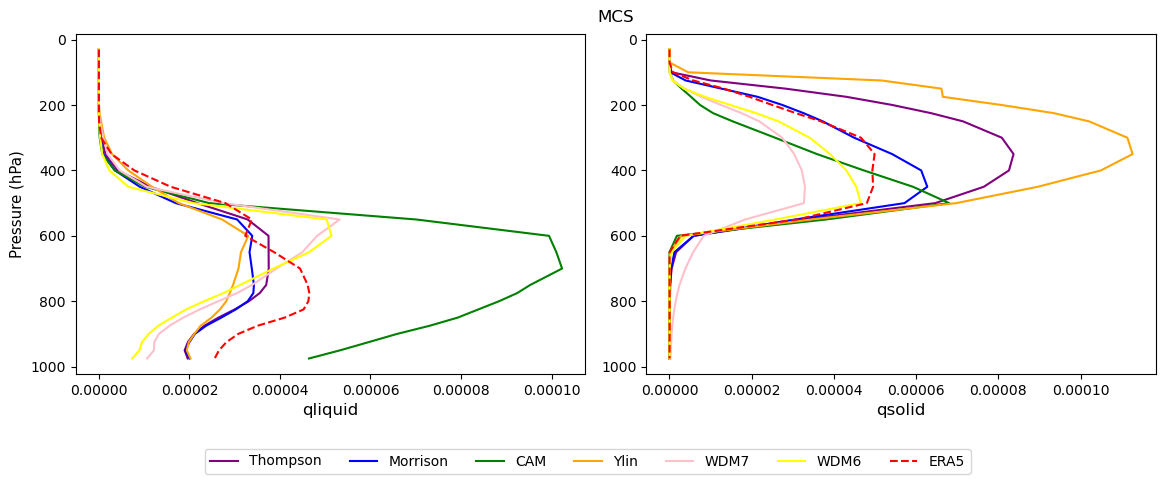

In [51]:
### Plot
nrows, ncols = 1,2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,4))
axs = axs.flatten()
fig.suptitle('MCS', y=1.01)

#
axs[0].plot(Qliquid_tho, imeanl_qstho.level, color='purple', label='Thompson')
axs[0].plot(Qliquid_mor, imeanl_qstho.level, color='blue', label='Morrison')
axs[0].plot(Qliquid_cam, imeanl_qstho.level, color='green', label='CAM')
axs[0].plot(Qliquid_ylin, imeanl_qstho.level, color='orange', label='Ylin')
axs[0].plot(Qliquid_wdm7, imeanl_qstho.level, color='pink', label='WDM7')
axs[0].plot(Qliquid_wdm6, imeanl_qstho.level, color='yellow', label='WDM6')
axs[0].plot(Qliquid_ERA, imeanl_qstho.level, linestyle='dashed', color='r', label='ERA5')
axs[0].invert_yaxis()
axs[0].set_ylabel(r'Pressure (hPa)', fontsize=10.8)
axs[0].set_xlabel(r'qliquid', fontsize=12)

#
axs[1].plot(Qsolid_tho, imeanl_qstho.level, color='purple', label='Thompson')
axs[1].plot(Qsolid_mor, imeanl_qstho.level, color='blue', label='Morrison')
axs[1].plot(Qsolid_cam, imeanl_qstho.level, color='green', label='CAM')
axs[1].plot(Qsolid_ylin, imeanl_qstho.level, color='orange', label='Ylin')
axs[1].plot(Qsolid_wdm7, imeanl_qstho.level, color='pink', label='WDM7')
axs[1].plot(Qsolid_wdm6, imeanl_qstho.level, color='yellow', label='WDM6')
axs[1].plot(Qsolid_ERA, imeanl_qstho.level, linestyle='dashed', color='r', label='ERA5')
axs[1].invert_yaxis()
axs[1].legend(loc='upper right', ncol=7, bbox_to_anchor=(0.65, -0.2))
axs[1].set_xlabel(r'qsolid', fontsize=12)

plt.tight_layout()
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.12, hspace=0.25)

## Complete liquid and ice water paths

### Liquid water path (Qcloud + Qrain)

In [50]:
def WP1D(values, pressure_levels):
    """ This function calculates the water path (column-integrated water content) from hydrometeors mixing ratios. 

    Parameters: 
       values(array-like): field of hydrometeor (both 2D: level, time and 3D: level,lat,lon)
       pressure_levels(array-like): 1D field with corresponding pressure levels in hPa                       

    Returns: 
       field with column-integrated values (both 1D: time series and 2D: maps)
    """

    g = 9.81 # gravitational acceleration (needed because levels are given in pressure rather than height)                                                                                                                   
    return (np.trapz(values, pressure_levels, axis = 0)/g)*100 #axis=0 integrated along vertical dimension

In [53]:
# LIQUID WATER PATH USING QCLOUD + QRAIN
# Thompson
qrc_tho = iimeanl_qrtho + iimeanl_qctho   # Water mixing ratio in kg/kg averaged over 2d space
llwp_tho = WP1D(qrc_tho, qrc_tho.level)

# Morrison
qrc_mor = iimeanl_qrmor + iimeanl_qcmor          
llwp_mor = WP1D(qrc_mor, qrc_mor.level)

# CAM
qrc_cam = iimeanl_qrcam + iimeanl_qccam      
llwp_cam = WP1D(qrc_cam, qrc_cam.level)

# Ylin
qrc_ylin = iimeanl_qrylin + iimeanl_qcylin 
llwp_ylin = WP1D(qrc_ylin, qrc_ylin.level)

# WDM7
qrc_wdm7 = iimeanl_qrwdm7 + iimeanl_qcwdm7       
llwp_wdm7 = WP1D(qrc_wdm7, qrc_wdm7.level)

# WDM6
qrc_wdm6 = iimeanl_qrwdm6 + iimeanl_qcwdm6
llwp_wdm6 = WP1D(qrc_wdm6, qrc_wdm6.level)

# ERA
qrc_ERA = iimeanl_qrERA + iimeanl_qcERA       
llwp_ERA = WP1D(qrc_ERA, qrc_ERA.level)

In [54]:
# Calculate daily mean and then plot 9 points
groups = [[llwp_tho[x:x+24] for x in range(0, len(llwp_tho), 24)], [llwp_mor[x:x+24] for x in range(0, len(llwp_mor), 24)], [llwp_cam[x:x+24] for x in range(0, len(llwp_cam), 24)], [llwp_ylin[x:x+24] for x in range(0, len(llwp_ylin), 24)], [llwp_wdm7[x:x+24] for x in range(0, len(llwp_wdm7), 24)], [llwp_wdm6[x:x+24] for x in range(0, len(llwp_wdm6), 24)], [llwp_ERA[x:x+24] for x in range(0, len(llwp_ERA), 24)]]

# Simple math to calculate the means
avgdaily_llwp= np.zeros([7,9])
for m in range(0,7):#number of datasets
 for i in range(0,9): #nine days
    avgdaily_llwp[m][i] = sum(groups[m][i])/24;

#days
days= ['2008-07-16', '2008-07-17','2008-07-18', '2008-07-19','2008-07-20', '2008-07-21','2008-07-22', '2008-07-23', '2008-07-24']

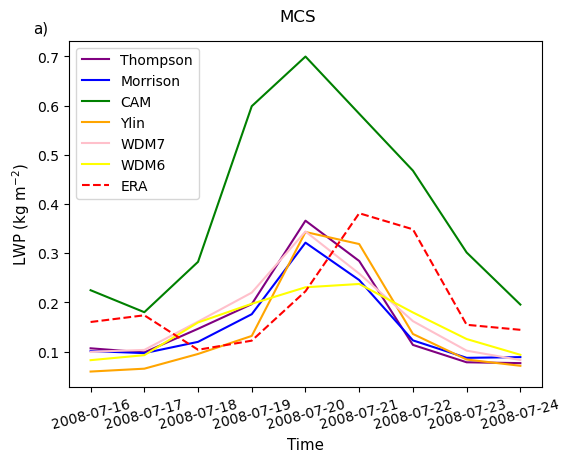

In [55]:
# Liquid water path (Qcloud+Qrain) timeseries but average daily
fig = plt.subplots(figsize=(6.1,4.5))

# Plot
plt.plot(days, avgdaily_llwp[0], color='purple', label='Thompson')
plt.plot(days, avgdaily_llwp[1], color='blue', label='Morrison')
plt.plot(days, avgdaily_llwp[2], color='green', label='CAM')
plt.plot(days, avgdaily_llwp[3], color='orange', label='Ylin')
plt.plot(days, avgdaily_llwp[4], color='pink', label='WDM7')
plt.plot(days, avgdaily_llwp[5], color='yellow', label='WDM6')
plt.plot(days, avgdaily_llwp[6], linestyle='dashed', color='r', label='ERA')

plt.suptitle('MCS', y=0.95)
plt.title('a)', x=-0.06, fontsize=10.8)
plt.ylabel(r'LWP (kg m$^{-2}$)', fontsize=10.8)
plt.xlabel(r'Time', fontsize=10.8)
plt.tick_params(axis='x', labelrotation = 15)
#plt.grid(alpha=0.3)
plt.legend(loc='upper left')

### Ice water path (Qice + Qsnow + Qgraup + Qhail)

In [51]:
# ICE WATER PATH USING QSNOW + QICE + QGRAUP + QHAIL

# Thompson
qq_tho = iimeanl_qstho + iimeanl_qitho + iimeanl_qgtho   # Water mixing ratio in kg/kg averaged over 2d space
qqwp_tho = WP1D(qq_tho, qq_tho.level)

# Morrison
qq_mor = iimeanl_qsmor + iimeanl_qimor + iimeanl_qgmor        
qqwp_mor = WP1D(qq_mor, qq_tho.level)

# CAM
qq_cam = iimeanl_qscam + iimeanl_qicam         
qqwp_cam = WP1D(qq_cam, qq_cam.level)

# Ylin
qq_ylin = iimeanl_qsylin + iimeanl_qiylin    
qqwp_ylin = WP1D(qq_ylin, qq_ylin.level)

# WDM7
qq_wdm7 = iimeanl_qswdm7 + iimeanl_qiwdm7 + iimeanl_qgwdm7  + iimeanl_qhwdm7 #here use also hail!!    
qqwp_wdm7 = WP1D(qq_wdm7, qq_wdm7.level)

# WDM6
qq_wdm6 = iimeanl_qswdm6 + iimeanl_qiwdm6 + iimeanl_qgwdm6        
qqwp_wdm6 = WP1D(qq_wdm6, qq_wdm6.level)

# ERA
qq_ERA = iimeanl_qsERA + iimeanl_qiERA        
qqwp_ERA = WP1D(qq_ERA, qq_ERA.level)

In [52]:
# Calculate daily mean and then plot 9 points
groups = [[qqwp_tho[x:x+24] for x in range(0, len(qqwp_tho), 24)], [qqwp_mor[x:x+24] for x in range(0, len(qqwp_mor), 24)], [qqwp_cam[x:x+24] for x in range(0, len(qqwp_cam), 24)], [qqwp_ylin[x:x+24] for x in range(0, len(qqwp_ylin), 24)], [qqwp_wdm7[x:x+24] for x in range(0, len(qqwp_wdm7), 24)], [qqwp_wdm6[x:x+24] for x in range(0, len(qqwp_wdm6), 24)], [qqwp_ERA[x:x+24] for x in range(0, len(qqwp_ERA), 24)]]

# Simple math to calculate the means
avgdaily_qqwp = np.zeros([7,9])
for m in range(0,7):#number of datasets
 for i in range(0,9): #nine days
    avgdaily_qqwp[m][i] = sum(groups[m][i])/24;

#days
days= ['2008-07-16', '2008-07-17','2008-07-18', '2008-07-19','2008-07-20', '2008-07-21','2008-07-22', '2008-07-23', '2008-07-24']

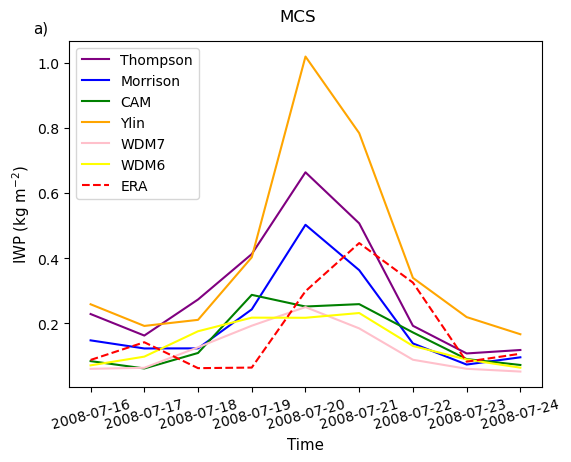

In [53]:
# Ice water path (Qice+Qsnow+Qgraup+Qhail) timeseries but average daily Article
fig = plt.subplots(figsize=(6.1,4.5))

# Plot
plt.plot(days, avgdaily_qqwp[0], color='purple', label='Thompson')
plt.plot(days, avgdaily_qqwp[1], color='blue', label='Morrison')
plt.plot(days, avgdaily_qqwp[2], color='green', label='CAM')
plt.plot(days, avgdaily_qqwp[3], color='orange', label='Ylin')
plt.plot(days, avgdaily_qqwp[4], color='pink', label='WDM7')
plt.plot(days, avgdaily_qqwp[5], color='yellow', label='WDM6')
plt.plot(days, avgdaily_qqwp[6], linestyle='dashed', color='r', label='ERA')

plt.suptitle('MCS', y=0.95)
plt.title('a)', x=-0.06, fontsize=10.8)
plt.ylabel(r'IWP (kg m$^{-2}$)', fontsize=10.8)
plt.xlabel(r'Time', fontsize=10.8)
plt.tick_params(axis='x', labelrotation = 15)
#plt.grid(alpha=0.3)
plt.legend(loc='upper left')

## Maps of complete liquid and ice water paths

In [54]:
def WP2D(values, pressure_levels):
    """ This function calculates the water path (column-integrated water content) from hydrometeors mixing ratios. 

    Parameters: 
       values(array-like): field of hydrometeor (3D: level,lat,lon)
       pressure_levels(array-like): 1D field with corresponding pressure levels in hPa                       

    Returns: 
       field with column-integrated values (2D: maps)
    """
    Dpres = np.zeros((29,37,57))
    for o in range(0,57):
     for m in range(0,37):
      for n in range(0,29):
        Dpres[n][m][o] = pressure_levels[n]; 
    Dql = values   # Water mixing ratio in kg/kg 
    Dpl = Dpres * 100.0   # Convert pressure levels to Pa
    Ddp = np.zeros((28,37,57)) # Define arrays to put in the results
    Dlwp = np.zeros((37,57))
    for n in range(0,28): #compute
     for m in range(0,37):
      for o in range(0,57):   
       Ddp[n][m][o] = Dpl[n][m][o] - Dpl[n-1][m][o]
    Dlwp = (np.nansum(Dql[1:29] * Ddp, axis=0))/9.81
          
    return Dlwp #water path (lat,lon)

In [60]:
# Compute 2d liquid water path using Qcloud

# Thompson
Dql_tho = dsi_qcthoc    # Water mixing ratio in kg/kg 
Dlwp_tho = WP2D(Dql_tho, Dql_tho.level) # Compute the liquid water path (LWP) in kg/m2: drop level 30 hPa

# Morrison
Dql_mor = dsi_qcmorc        
Dlwp_mor = WP2D(Dql_mor, Dql_mor.level)

# CAM
Dql_cam = dsi_qccamc       
Dlwp_cam = WP2D(Dql_cam, Dql_cam.level)

# Ylin 
Dql_ylin = dsi_qcylinc        
Dlwp_ylin = WP2D(Dql_ylin, Dql_ylin.level)

# WDM7
Dql_wdm7 = dsi_qcwdm7c        
Dlwp_wdm7 = WP2D(Dql_wdm7, Dql_wdm7.level)

# WDM6
Dql_wdm6 = dsi_qcwdm6c        
Dlwp_wdm6 = WP2D(Dql_wdm6, Dql_wdm6.level)

# ERA5
# Mean over time
dsi_qcERA = dsl_qcERA.mean(dim=('time')).clwc

# Liquid water path
Dql_ERA = dsi_qcERA    # Water mixing ratio in kg/kg
Dlwp_ERA = WP2D(Dql_ERA, Dql_ERA.level)

### LWP (Qcloud+Qrain)

In [61]:
# Compute 2d liquid water path using Qcloud+Qrain

# Thompson
Dql_tho = dsi_qcthoc + dsi_qrthoc   # Water mixing ratio in kg/kg 
Dllwp_tho = WP2D(Dql_tho, Dql_tho.level) # Compute the liquid water path (LWP) in kg/m2: drop level 30 hPa

# Morrison
Dql_mor = dsi_qcmorc + dsi_qrmorc      
Dllwp_mor = WP2D(Dql_mor, Dql_mor.level)

# CAM
Dql_cam = dsi_qccamc + dsi_qrcamc       
Dllwp_cam = WP2D(Dql_cam, Dql_cam.level)

# Ylin   
Dql_ylin = dsi_qcylinc + dsi_qrylinc     
Dllwp_ylin = WP2D(Dql_ylin, Dql_ylin.level)

# WDM7
Dql_wdm7 = dsi_qcwdm7c + dsi_qrwdm7c    
Dllwp_wdm7 = WP2D(Dql_wdm7, Dql_wdm7.level)

# WDM6
Dql_wdm6 = dsi_qcwdm6c + dsi_qrwdm6c       
Dllwp_wdm6 = WP2D(Dql_wdm6, Dql_wdm6.level)

# ERA5
dsi_qrERA = dsl_qrERA.mean(dim=('time')).crwc

Dql_ERA = dsi_qcERA + dsi_qrERA   # Water mixing ratio in kg/kg
Dllwp_ERA = WP2D(Dql_ERA, Dql_ERA.level)

In [62]:
# Maps of IWP () Article
# Elevation
elevation_data =  xr.open_dataset('/media/irene/Elements/Laptop_dec2023/Thesis_data/script/scripts29May/geopotential.nc')
height = elevation_data/9.81
height = height.sel(latitude=slice(35,26), longitude=slice(100,114))

/tmp/ipykernel_2906/2778481878.py:27: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cs0.collections:


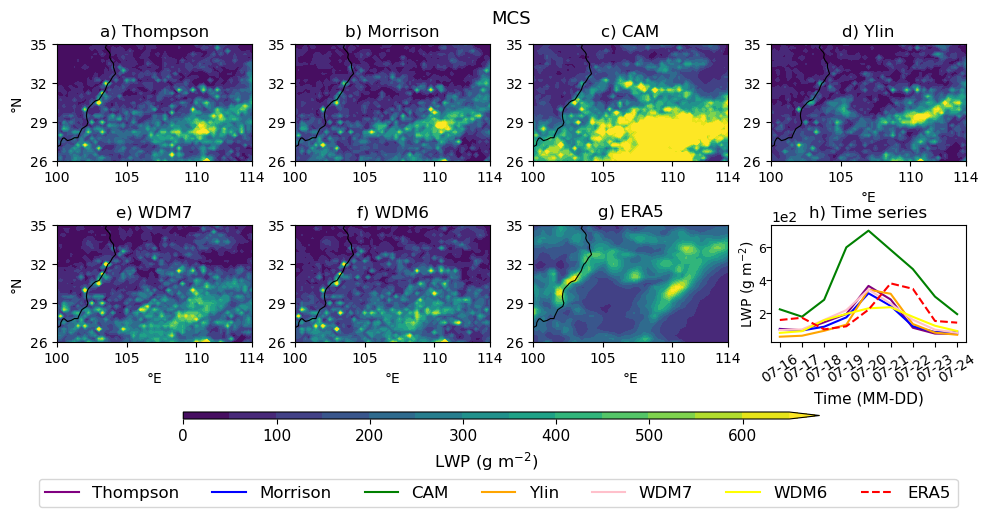

In [81]:
# Maps of LWP (Qice+Qsnow+Qgraup+Qhail)
timess= ['07-16', '07-17','07-18', '07-19','07-20', '07-21','07-22', '07-23', '07-24']

ds_Dllwp = [Dllwp_tho, Dllwp_mor, Dllwp_cam, Dllwp_ylin, Dllwp_wdm7, Dllwp_wdm6, Dllwp_ERA]
title = ['a) Thompson', 'b) Morrison', 'c) CAM', 'd) Ylin', 'e) WDM7', 'f) WDM6', 'g) ERA5']

#set clevels and color
cmap=plt.cm.viridis
clevs=np.arange(0,700,50)
clevs1=np.arange(0,850,50)

#create figure
nrows, ncols = 2,4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10.1,3.5))
axs = axs.flatten()
fig.suptitle('MCS', y=1.05, fontsize=13)

for i in range(0,7):
 axs[i].tick_params(axis='x', labelsize=10)  
 axs[i].tick_params(axis='y', labelsize=10)
 axs[i].set_xticks([100,105,110,114])
 axs[i].set_yticks([26,29,32,35])
 axs[i].contour(height.z.longitude.values , height.z.latitude.values, height.z[0], levels=[3000], colors='black', linewidths=0.8)
 cs0 = axs[i].contourf(ds_ERAc.longitude, ds_ERAc.latitude, ds_Dllwp[i]*1000, clevs, cmap=cmap, extend='max')
 axs[i].set_title(f'{(3*title)[i]}', fontsize=12)
 # Rasterize just the color field (important!)
 for col in cs0.collections:
    col.set_rasterized(True)

axs[0].set_ylabel('°N',fontsize=10)
axs[3].set_xlabel('°E',fontsize=10)
axs[4].set_xlabel('°E',fontsize=10)
axs[4].set_ylabel('°N',fontsize=10)
axs[5].set_xlabel('°E',fontsize=10)
axs[6].set_xlabel('°E',fontsize=10)

# plot
axs[7].plot(timess, avgdaily_llwp[0]*1000, color='purple', label='Thompson')
axs[7].plot(timess, avgdaily_llwp[1]*1000, color='blue', label='Morrison')
axs[7].plot(timess, avgdaily_llwp[2]*1000, color='green', label='CAM')
axs[7].plot(timess, avgdaily_llwp[3]*1000, color='orange', label='Ylin')
axs[7].plot(timess, avgdaily_llwp[4]*1000, color='pink', label='WDM7')
axs[7].plot(timess, avgdaily_llwp[5]*1000, color='yellow', label='WDM6')
axs[7].plot(timess, avgdaily_llwp[6]*1000, color='r', linestyle='dashed' ,label='ERA5')
axs[7].tick_params(axis='x', rotation=33, labelsize=10)
axs[7].tick_params(axis='y', labelsize=9, pad=-0.1)
axs[7].set_title('h) Time series', fontsize=12)
axs[7].set_ylabel(r'LWP (g m$^{-2}$)', fontsize=10, labelpad=-0.2)
axs[7].set_xlabel(r'Time (MM-DD)', fontsize=11)
# format scale of y axis
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 1))
axs[7].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
offset_text = axs[7].yaxis.get_offset_text()
offset_text.set_fontsize(10) 

# Adjust layout to prevent clipping of axis labels
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.22, hspace=0.55)
# Add colorbar
cbar_ax = fig.add_axes([0.175, -0.12, 0.63, 0.02])
cbar=plt.colorbar(cs0, cax=cbar_ax, orientation='horizontal', extend='max')
axs[7].legend(loc='upper right', ncol=7, bbox_to_anchor=(1, -1.1), fontsize=12)
cbar.set_label(r'LWP (g m$^{-2}$)', fontsize = 12)
cbar.ax.tick_params(labelsize=11)

cbar.solids.set_edgecolor("face")
cbar.solids.set_rasterized(True)
# Save to SVG
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission_svg/lwp-maps-mcs-svg.svg',
            format='svg', dpi=400, bbox_inches='tight')
# Save the plot as a hd file
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/lwp-maps-mcs.png', dpi=400, bbox_inches='tight')

### IWP (Qice+Qsnow+Qgraupel+Qhail)

In [55]:
# Compute 2d liquid water path using Qice+Qsnow+Qgraupel

# Thompson
Dqi_tho = dsi_qithoc + dsi_qsthoc + dsi_qgthoc   # Water mixing ratio in kg/kg 
Diiwp_tho = WP2D(Dqi_tho, Dqi_tho.level)

# Morrison
Dqi_mor = dsi_qimorc + dsi_qsmorc + dsi_qgmorc      
Diiwp_mor = WP2D(Dqi_mor, Dqi_mor.level)

# CAM
Dqi_cam = dsi_qicamc + dsi_qscamc    
Diiwp_cam = WP2D(Dqi_cam, Dqi_cam.level)

# Ylin  
Dqi_ylin = dsi_qiylinc + dsi_qsylinc      
Diiwp_ylin = WP2D(Dqi_ylin, Dqi_ylin.level)

# WDM7
Dqi_wdm7 = dsi_qiwdm7c + dsi_qswdm7c + dsi_qgwdm7c + dsi_qhwdm7c   
Diiwp_wdm7 = WP2D(Dqi_wdm7, Dqi_wdm7.level)

# WDM6
Dqi_wdm6 = dsi_qiwdm6c + dsi_qswdm6c + dsi_qgwdm6c       
Diiwp_wdm6 = WP2D(Dqi_wdm6, Dqi_wdm6.level)

# ERA5
# mean over time
dsi_qiERA = dsl_qiERA.mean(dim=('time')).ciwc
dsi_qsERA = dsl_qsERA.mean(dim=('time')).cswc

#ice water path
Dql_ERA = dsi_qiERA + dsi_qsERA   # Water mixing ratio in kg/kg
Diiwp_ERA = WP2D(Dql_ERA, Dql_ERA.level)

In [56]:
# Maps of IWP () Article
# Elevation
elevation_data =  xr.open_dataset('/media/irene/Elements/Laptop_dec2023/Thesis_data/script/scripts29May/geopotential.nc')
height = elevation_data/9.81
height = height.sel(latitude=slice(35,26), longitude=slice(100,114))

/tmp/ipykernel_4887/877780735.py:27: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cs0.collections:


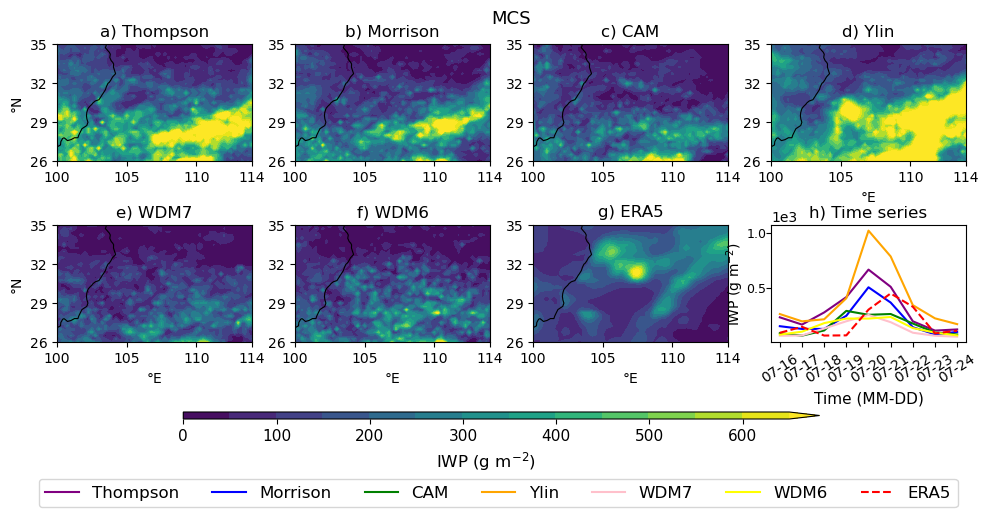

In [60]:
# Maps of LWP (Qice+Qsnow+Qgraup+Qhail)
timess= ['07-16', '07-17','07-18', '07-19','07-20', '07-21','07-22', '07-23', '07-24']

ds_Diiwp = [Diiwp_tho, Diiwp_mor, Diiwp_cam, Diiwp_ylin, Diiwp_wdm7, Diiwp_wdm6, Diiwp_ERA]
title = ['a) Thompson', 'b) Morrison', 'c) CAM', 'd) Ylin', 'e) WDM7', 'f) WDM6', 'g) ERA5']

#set clevels and color
cmap=plt.cm.viridis
clevs=np.arange(0,700,50)
clevs1=np.arange(0,850,50)

#create figure
nrows, ncols = 2,4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10.1,3.5))
axs = axs.flatten()
fig.suptitle('MCS', y=1.05, fontsize=13)

for i in range(0,7):
 axs[i].tick_params(axis='x', labelsize=10)  
 axs[i].tick_params(axis='y', labelsize=10)
 axs[i].set_xticks([100,105,110,114])
 axs[i].set_yticks([26,29,32,35])
 axs[i].contour(height.z.longitude.values , height.z.latitude.values, height.z[0], levels=[3000], colors='black', linewidths=0.8)
 cs0 = axs[i].contourf(ds_ERAc.longitude, ds_ERAc.latitude, ds_Diiwp[i]*1000, clevs, cmap=cmap, extend='max')
 axs[i].set_title(f'{(3*title)[i]}', fontsize=12)
 # Rasterize just the color field (important!)
 for col in cs0.collections:
    col.set_rasterized(True)
     
axs[0].set_ylabel('°N',fontsize=10)
axs[3].set_xlabel('°E',fontsize=10)
axs[4].set_xlabel('°E',fontsize=10)
axs[4].set_ylabel('°N',fontsize=10)
axs[5].set_xlabel('°E',fontsize=10)
axs[6].set_xlabel('°E',fontsize=10)

# plot
axs[7].plot(timess, avgdaily_qqwp[0]*1000, color='purple', label='Thompson')
axs[7].plot(timess, avgdaily_qqwp[1]*1000, color='blue', label='Morrison')
axs[7].plot(timess, avgdaily_qqwp[2]*1000, color='green', label='CAM')
axs[7].plot(timess, avgdaily_qqwp[3]*1000, color='orange', label='Ylin')
axs[7].plot(timess, avgdaily_qqwp[4]*1000, color='pink', label='WDM7')
axs[7].plot(timess, avgdaily_qqwp[5]*1000, color='yellow', label='WDM6')
axs[7].plot(timess, avgdaily_qqwp[6]*1000, color='r', linestyle='dashed' ,label='ERA5')
axs[7].tick_params(axis='x', rotation=33, labelsize=10)
axs[7].tick_params(axis='y', labelsize=9, pad=-0.1)
axs[7].set_title('h) Time series', fontsize=12)
axs[7].set_ylabel(r'IWP (g m$^{-2}$)', fontsize=10, labelpad=0.5)
axs[7].set_xlabel(r'Time (MM-DD)', fontsize=11)
# format scale of y axis
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 1))
axs[7].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
offset_text = axs[7].yaxis.get_offset_text()
offset_text.set_fontsize(10) 

# Adjust layout to prevent clipping of axis labels
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.22, hspace=0.55)
# Add colorbar
cbar_ax = fig.add_axes([0.175, -0.12, 0.63, 0.02])
cbar=plt.colorbar(cs0, cax=cbar_ax, orientation='horizontal', extend='max')
axs[7].legend(loc='upper right', ncol=7, bbox_to_anchor=(1, -1.1), fontsize=12)
cbar.set_label(r'IWP (g m$^{-2}$)', fontsize = 12)
cbar.ax.tick_params(labelsize=11)

cbar.solids.set_edgecolor("face")
cbar.solids.set_rasterized(True)
# Save to SVG
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission_svg/iwp-maps-mcs-svg.svg',
            format='svg', dpi=400, bbox_inches='tight')

# Save the plot as a hd file
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/iwp-maps-mcs.png', dpi=400, bbox_inches='tight')

## Partial correlation with standardised complete ice and liquid water path

In [ ]:
# Mean over latitude and longitude to have values vs time (*24, *86400 to have mm/day) of precipitation
means_rprthoc = (ds_rprthoc.PREC_ACC_NC*24).mean(dim=('latitude','longitude'))
means_rprmorc = (ds_rprmorc.PREC_ACC_NC*24).mean(dim=('latitude','longitude'))
means_rprcamc = (ds_rprcamc.PREC_ACC_NC*24).mean(dim=('latitude','longitude'))
means_rprylinc = (ds_rprylinc.PREC_ACC_NC*24).mean(dim=('latitude','longitude'))
means_rprwdm7c = (ds_rprwdm7c.PREC_ACC_NC*24).mean(dim=('latitude','longitude'))
means_rprwdm6c = (ds_rprwdm6c.PREC_ACC_NC*24).mean(dim=('latitude','longitude'))

means_prERAc = (ds_prERAc.mtpr*86400).mean(dim=('latitude','longitude'))

In [ ]:
# Mean over 3d space for QCLOUD
means_qcthoc = (ds_qcthoc.QCLOUD).mean(dim=('latitude','longitude','bottom_top'))
means_qcmorc = (ds_qcmorc.QCLOUD).mean(dim=('latitude','longitude','bottom_top'))
means_qccamc = (ds_qccamc.QCLOUD).mean(dim=('latitude','longitude','bottom_top'))
means_qcylinc = (ds_qcylinc.QCLOUD).mean(dim=('latitude','longitude','bottom_top'))
means_qcwdm7c = (ds_qcwdm7c.QCLOUD).mean(dim=('latitude','longitude','bottom_top'))
means_qcwdm6c = (ds_qcwdm6c.QCLOUD).mean(dim=('latitude','longitude','bottom_top'))

# Using only 29 levels shared with WRF
ds_clwERAc = ds_clwERA.sel(level=ulev)
means_clwERAc = (ds_clwERAc.clwc).mean(dim=('latitude','longitude','level'))

In [ ]:
# Mean over 3d space for QICE
means_qithoc = (ds_qithoc.QICE).mean(dim=('latitude','longitude','bottom_top'))
means_qimorc = (ds_qimorc.QICE).mean(dim=('latitude','longitude','bottom_top'))
means_qicamc = (ds_qicamc.QICE).mean(dim=('latitude','longitude','bottom_top'))
means_qiylinc = (ds_qiylinc.QICE).mean(dim=('latitude','longitude','bottom_top'))
means_qiwdm7c = (ds_qiwdm7c.QICE).mean(dim=('latitude','longitude','bottom_top'))
means_qiwdm6c = (ds_qiwdm6c.QICE).mean(dim=('latitude','longitude','bottom_top'))

# Using only 29 levels shared with WRF
ds_ciwERAc = ds_ciwERA.sel(level=ulev)
means_ciwERAc = (ds_ciwERAc.ciwc).mean(dim=('latitude','longitude','level'))

In [ ]:
# Define list of datasets to standardise
means_pr = [means_rprthoc, means_rprmorc, means_rprcamc, means_rprylinc, means_rprwdm7c, means_rprwdm6c, means_prERAc]
means_llwp = [llwp_tho, llwp_mor, llwp_cam, llwp_ylin, llwp_wdm7, llwp_wdm6, llwp_ERA]
means_iiwp = [qqwp_tho ,qqwp_mor ,qqwp_cam ,qqwp_ylin ,qqwp_wdm7 ,qqwp_wdm6 ,qqwp_ERA ]

# Define arrays in which put results for things within loops
mean_pr, mean_llwp, mean_iiwp = np.zeros(7), np.zeros(7), np.zeros(7) 
stddev_pr, stddev_llwp, stddev_iiwp = np.zeros(7), np.zeros(7), np.zeros(7) 
std_pr, std_llwp, std_iiwp = np.zeros([7,216]), np.zeros([7,216]), np.zeros([7,216])

# Calculate mean and standard deviation for each variable and each scheme
for i in range(0,len(means_llwp)):
    mean_pr[i] = np.mean(means_pr[i])
    stddev_pr[i] = np.std(means_pr[i])
    mean_llwp[i] = np.mean(means_llwp[i])
    stddev_llwp[i] = np.std(means_llwp[i])
    mean_iiwp[i] = np.mean(means_iiwp[i])
    stddev_iiwp[i] = np.std(means_iiwp[i])
    # Compute standardised variables
    std_pr[i] = (means_pr[i] - mean_pr[i]) / stddev_pr[i]
    std_llwp[i] = (means_llwp[i] - mean_llwp[i]) / stddev_llwp[i]
    std_iiwp[i] = (means_iiwp[i] - mean_iiwp[i]) / stddev_iiwp[i];

In [ ]:
# Compute partial correlation for each scheme
titl = ['Thompson', 'Morrison', 'CAM', 'Ylin', 'WDM7', 'WDM6', 'ERA5']

for i in range(0,7):
    datas = {'Precip':  std_pr[i], 'LWP': std_llwp[i], 'IWP': std_iiwp[i], }
    dfs = pd.DataFrame(datas, columns = ['Precip', 'LWP', 'IWP'])

    print(f'Partial correlation coefficient {(3*titl)[i]} of Precip') 
    print("LWP:")
    print(pg.partial_corr(data=dfs, x='Precip', y='LWP', covar='IWP')) 
    print("IWP:")
    print(pg.partial_corr(data=dfs, x='Precip', y='IWP', covar='LWP'))
    print("******************************************************************");

### Decycling ALL

In [ ]:
# Decycling: do the mean for all the means and use that as a reference
# Precipitation

mean1 = (means_prERAc.values + means_rprthoc + means_rprmorc + means_rprcamc + means_rprylinc + means_rprwdm7c + means_rprwdm7c)/7
#to be able to do difference with era5
mean1s = mean1.rename({'XTIME': 'time'})

# Compute the difference: precipitation decycled
dec_prthoc = (means_rprthoc.values - mean1.values )
dec_prmorc = (means_rprmorc.values - mean1.values )
dec_prcamc = (means_rprcamc.values - mean1.values )
dec_prylinc = (means_rprylinc.values - mean1.values )
dec_prwdm7c = (means_rprwdm7c.values - mean1.values )
dec_prwdm6c = (means_rprwdm6c.values - mean1.values)
dec_prERAc = (means_prERAc.values - mean1s.values )

In [ ]:
# Decycling: do the mean for all the means and use that as a reference
# LWP

meanl = (llwp_tho + llwp_mor + llwp_cam + llwp_ylin + llwp_wdm7 + llwp_wdm6 + llwp_ERA)/7


# Compute the difference: precipitation decycled
dec_llthoc = (llwp_tho - meanl )
dec_llmorc = (llwp_mor - meanl )
dec_llcamc = (llwp_cam - meanl )
dec_llylinc = (llwp_ylin - meanl )
dec_llwdm7c = (llwp_wdm7 - meanl )
dec_llwdm6c = (llwp_wdm6 - meanl )
dec_llERAc = (llwp_ERA- meanl )

In [ ]:
# Decycling: do the mean for all the means and use that as a reference
# IWP

meanq = (qqwp_tho + qqwp_mor + qqwp_cam + qqwp_ylin + qqwp_wdm7 + qqwp_wdm6 + qqwp_ERA)/7


# Compute the difference: precipitation decycled
dec_qqthoc = (qqwp_tho - meanq )
dec_qqmorc = (qqwp_mor - meanq )
dec_qqcamc = (qqwp_cam - meanq )
dec_qqylinc = (qqwp_ylin - meanq )
dec_qqwdm7c = (qqwp_wdm7 - meanq )
dec_qqwdm6c = (qqwp_wdm6 - meanq )
dec_qqERAc = (qqwp_ERA- meanq )

In [ ]:
# Define list of datasets to standardise
means_pr = [dec_prthoc, dec_prmorc, dec_prcamc, dec_prylinc, dec_prwdm7c, dec_prwdm6c, dec_prERAc]
means_llwp = [dec_llthoc,dec_llmorc, dec_llcamc, dec_llylinc, dec_llwdm7c, dec_llwdm6c, dec_llERAc]
means_iiwp = [dec_qqthoc,dec_qqmorc, dec_qqcamc, dec_qqylinc, dec_qqwdm7c, dec_qqwdm6c, dec_qqERAc]

# Define arrays in which put results for things within loops
mean_pr, mean_llwp, mean_iiwp = np.zeros(7), np.zeros(7), np.zeros(7) 
stddev_pr, stddev_llwp, stddev_iiwp = np.zeros(7), np.zeros(7), np.zeros(7) 
std_pr, std_llwp, std_iiwp = np.zeros([7,216]), np.zeros([7,216]), np.zeros([7,216])

# Calculate mean and standard deviation for each variable and each scheme
for i in range(0,len(means_llwp)):
    mean_pr[i] = np.mean(means_pr[i])
    stddev_pr[i] = np.std(means_pr[i])
    mean_llwp[i] = np.mean(means_llwp[i])
    stddev_llwp[i] = np.std(means_llwp[i])
    mean_iiwp[i] = np.mean(means_iiwp[i])
    stddev_iiwp[i] = np.std(means_iiwp[i])
    # Compute standardised variables
    std_pr[i] = (means_pr[i] - mean_pr[i]) / stddev_pr[i]
    std_llwp[i] = (means_llwp[i] - mean_llwp[i]) / stddev_llwp[i]
    std_iiwp[i] = (means_iiwp[i] - mean_iiwp[i]) / stddev_iiwp[i];

In [ ]:
# Compute partial correlation for each scheme
titl = ['Thompson', 'Morrison', 'CAM', 'Ylin', 'WDM7', 'WDM6', 'ERA5']

for i in range(0,7):
    datas = {'Precip':  std_pr[i], 'LWP': std_llwp[i], 'IWP': std_iiwp[i], }
    dfs = pd.DataFrame(datas, columns = ['Precip', 'LWP', 'IWP'])

    print(f'Partial correlation coefficient {(3*titl)[i]} of Precip_decycled_all') 
    print("LWP:")
    print(pg.partial_corr(data=dfs, x='Precip', y='LWP', covar='IWP')) 
    print("IWP:")
    print(pg.partial_corr(data=dfs, x='Precip', y='IWP', covar='LWP'))
    print("******************************************************************");